In [1]:
# Install required packages
!pip install rasterio geopandas tensorflow scikit-learn matplotlib seaborn tqdm gdown

# Import libraries
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gdown
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)

print("Environment setup complete!")


Environment setup complete!


In [2]:
# Make sure you have a data directory
os.makedirs('data', exist_ok=True)

# Dictionary of files and their Google Drive IDs
files = {
    'Humidity_Uttarakhand_30m.tif': '1dIjajkbiU8IVwKEsMny0rm583g4kWxrf',
    'LULC_MODIS_Uttarakhand_500m.tif': '1Vg_EZ8ENWfo5fLiQzgYjh6hZaue2cdCR',
    'NBR_Uttarakhand_30m.tif': '1l9FUBPycy7EpZ79x9ShUKwDcQ-cFUdom',
    'NDVI_Uttarakhand_30m.tif': '1Vd9ux8_TncGIQTV_BEwCTbaKlo6WsuG5',
    'Population_Uttarakhand_100m.tif': '1WoeP1YUHl0lJqhZVgT_ncWuww4klXGwu',
    'Rainfall_Uttarakhand_30m.tif': '1MIX-3QYZ_c9z9MimxrfU4L8b9re3gxN1',
    'Temperature_Uttarakhand_30m.tif': '1JaU689lWXxQg6fmcgM0PeI-1JfjAw71h',
    'VIIRS_Fire_Uttarakhand_30m.tif': '1rgUIqmTBRhLQzL7O_atKFf0S6ezvMD-c',
    'WindSpeed_Uttarakhand_30m.tif': '1vnEHmEMFWkexGgOox8CAmyVLdD2Gll9D'
}

# Download each file
for fname, file_id in files.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    out_path = os.path.join('data', fname)
    if not os.path.exists(out_path):
        print(f"Downloading {fname}...")
        gdown.download(url, out_path, quiet=False)
    else:
        print(f"{fname} already exists, skipping.")



Humidity_Uttarakhand_30m.tif already exists, skipping.
LULC_MODIS_Uttarakhand_500m.tif already exists, skipping.
NBR_Uttarakhand_30m.tif already exists, skipping.
NDVI_Uttarakhand_30m.tif already exists, skipping.


Downloading...
From: https://drive.google.com/uc?id=1WoeP1YUHl0lJqhZVgT_ncWuww4klXGwu
To: C:\Users\arins\data\Population_Uttarakhand_100m.tif
100%|███████████████████████████████████████████████████████████████████████████████| 357k/357k [00:00<00:00, 1.15MB/s]

Rainfall_Uttarakhand_30m.tif already exists, skipping.
Temperature_Uttarakhand_30m.tif already exists, skipping.
VIIRS_Fire_Uttarakhand_30m.tif already exists, skipping.
WindSpeed_Uttarakhand_30m.tif already exists, skipping.


In [3]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_Uttarakhand_100m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [4]:
file_id = '1WruddoB9Zz5q3FVMYikPfKfbhHZxAWVU'
url = f'https://drive.google.com/uc?id={file_id}'
out_path = os.path.join('data', 'MODIS_PFT_2023_Uttarakhand_30m.tif')

if not os.path.exists(out_path):
    print(f"Downloading MODIS_PFT_2023_Uttarakhand_30m.tif...")
    gdown.download(url, out_path, quiet=False)
else:
    print("Humidity_Uttarakhand_30m.tif already exists, skipping.")


Humidity_Uttarakhand_30m.tif already exists, skipping.


In [5]:
with rasterio.open('data/Humidity_Uttarakhand_30m.tif') as src:
    humidity = src.read(1)
    print("Shape:", humidity.shape)
    print("CRS:", src.crs)
    print("Resolution:", src.res)


Shape: (9551, 12917)
CRS: EPSG:4326
Resolution: (0.00026949458523585647, 0.00026949458523585647)


In [6]:
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def process_shapefiles(folder_path, label="Dataset"):
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            shp_path = os.path.join(folder_path, file)
            print(f"\nProcessing {label} shapefile: {file}")
            try:
                gdf = gpd.read_file(shp_path)
                print(gdf.head())  # Only prints first few rows
            except MemoryError:
                print("MemoryError: File too large to load in memory.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

# Process MODIS, VIIRS-Suomi, and VIIRS-J1 folders
process_shapefiles(modis_folder, label="MODIS")
process_shapefiles(viirs_snp_folder, label="VIIRS-Suomi")
process_shapefiles(viirs_j1_folder, label="VIIRS-J1")



Processing MODIS shapefile: fire_archive_M-C61_629985.shp
   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   30.0915    79.5024       304.5   1.2    1.1 2016-01-01     0517     Terra   
1   31.3276    77.0032       305.0   1.8    1.3 2016-01-01     0517     Terra   
2   29.8945    80.4499       325.8   1.1    1.1 2016-01-01     0518     Terra   
3   29.9037    80.4531       344.4   1.1    1.1 2016-01-01     0518     Terra   
4   27.2507    84.2995       317.8   1.1    1.0 2016-01-01     0518     Terra   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          58    6.03       285.8   8.7        D     0   
1      MODIS          49    6.03       292.2  16.1        D     0   
2      MODIS          84    6.03       290.4  27.9        D     0   
3      MODIS          94    6.03       289.8  60.2        D     0   
4      MODIS          78    6.03       296.0  14.3        D     0   

                  geometry  
0  POINT (

In [7]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_Uttarakhand_100m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [8]:
# Dictionary of file IDs and output filenames
file_dict = {
    'Uttarakhand_Elevation_30m.tif': '1eek_QQxkxQ8Ner2gG_cfZkFwz6nOU1Bk',
    'Uttarakhand_Slope_30m.tif': '1MyeCqOwCjByNYtkbdLHV2yaCup9H-mJo',
    'Uttarakhand_Aspect_30m.tif': '1qxIrde7H2O2b4P7uRcENbtpreNrr0DcF',
    'Uttarakhand_Hillshade_30m.tif': '1HPYjg2cCtcC5FRq6xKxW4lUNEWBHzqBZ'
}

# Make sure the 'data' directory exists
os.makedirs('data', exist_ok=True)

for filename, file_id in file_dict.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    out_path = os.path.join('data', filename)
    if not os.path.exists(out_path):
        print(f"Downloading {filename}...")
        gdown.download(url, out_path, quiet=False)
    else:
        print(f"{filename} already exists, skipping.")


Uttarakhand_Elevation_30m.tif already exists, skipping.
Uttarakhand_Slope_30m.tif already exists, skipping.
Uttarakhand_Aspect_30m.tif already exists, skipping.
Uttarakhand_Hillshade_30m.tif already exists, skipping.


In [9]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_Uttarakhand_100m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [10]:
# Print files in each folder
print("Files in MODIS folder:", os.listdir(modis_folder))
print("Files in VIIRS-Suomi folder:", os.listdir(viirs_snp_folder))
print("Files in VIIRS-J1 folder:", os.listdir(viirs_j1_folder))


Files in MODIS folder: ['fire_archive_M-C61_629985.cpg', 'fire_archive_M-C61_629985.dbf', 'fire_archive_M-C61_629985.prj', 'fire_archive_M-C61_629985.shp', 'fire_archive_M-C61_629985.shx', 'Readme.txt']
Files in VIIRS-Suomi folder: ['fire_archive_SV-C2_629987.cpg', 'fire_archive_SV-C2_629987.dbf', 'fire_archive_SV-C2_629987.prj', 'fire_archive_SV-C2_629987.shp', 'fire_archive_SV-C2_629987.shx', 'Readme.txt']
Files in VIIRS-J1 folder: ['fire_archive_J1V-C2_629986.cpg', 'fire_archive_J1V-C2_629986.dbf', 'fire_archive_J1V-C2_629986.prj', 'fire_archive_J1V-C2_629986.shp', 'fire_archive_J1V-C2_629986.shx', 'Readme.txt']


# DATA PREPROCESSING

1) Prepare uniform 30m resolution rasters aligned to a common grid :
   Resample LULC (500m → 30m)
   Resample Population (100m → 30m)
2) Stack All Rasters : Align all rasters to a common grid (extent, CRS, resolution).
   



In [11]:
import rasterio
from rasterio.enums import Resampling

def resample_raster(src_path, ref_path, dst_path, resampling=Resampling.bilinear):
    with rasterio.open(ref_path) as ref:
        ref_shape = (ref.height, ref.width)
        ref_transform = ref.transform
        ref_crs = ref.crs
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, ref_shape[0], ref_shape[1]),
            resampling=resampling
        )
        profile = src.profile
        profile.update({
            'height': ref_shape[0],
            'width': ref_shape[1],
            'transform': ref_transform,
            'crs': ref_crs
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(data)


In [12]:
from rasterio.mask import mask
import geopandas as gpd

def mask_raster(raster_path, shapefile_path, output_path):
    shapes = gpd.read_file(shapefile_path)
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


Align all features (raster layers) to a common 30m grid and stack them for model input.

In [13]:
# import numpy as np
# feature_paths = [
#     'NDVI_Uttarakhand_30m.tif',
#     'NBR_Uttarakhand_30m.tif',
#     'MODIS_PFT_2023_Uttarakhand_30m.tif',
#     'Temperature_Uttarakhand_30m.tif',
#     'Humidity_Uttarakhand_30m.tif',
#     'WindSpeed_Uttarakhand_30m.tif',
#     'Rainfall_Uttarakhand_30m.tif',
#     'Population_Uttarakhand_100m.tif',
#     'Uttarakhand_Elevation_30m.tif',
#     'Uttarakhand_Slope_30m.tif',
#     'Uttarakhand_Aspect_30m.tif'
#     # Add or remove files as needed for your use-case
# ]

# def stack_features(feature_paths):
#     arrays = []
#     for path in feature_paths:
#         with rasterio.open(path) as src:
#             arrays.append(src.read(1))
#     return np.stack(arrays, axis=-1)  # shape: (height, width, num_features)


In [14]:
# from sklearn.preprocessing import StandardScaler

# X = stack_features(feature_paths)  # shape: (height, width, num_features)
# scaler = StandardScaler()
#  X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


# VISUALISATION

In [15]:
!pip install rasterio matplotlib


Processing MODIS shapefile: fire_archive_M-C61_629985.shp
   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   30.0915    79.5024       304.5   1.2    1.1 2016-01-01     0517     Terra   
1   31.3276    77.0032       305.0   1.8    1.3 2016-01-01     0517     Terra   
2   29.8945    80.4499       325.8   1.1    1.1 2016-01-01     0518     Terra   
3   29.9037    80.4531       344.4   1.1    1.1 2016-01-01     0518     Terra   
4   27.2507    84.2995       317.8   1.1    1.0 2016-01-01     0518     Terra   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          58    6.03       285.8   8.7        D     0   
1      MODIS          49    6.03       292.2  16.1        D     0   
2      MODIS          84    6.03       290.4  27.9        D     0   
3      MODIS          94    6.03       289.8  60.2        D     0   
4      MODIS          78    6.03       296.0  14.3        D     0   

                  geometry  
0  POINT (

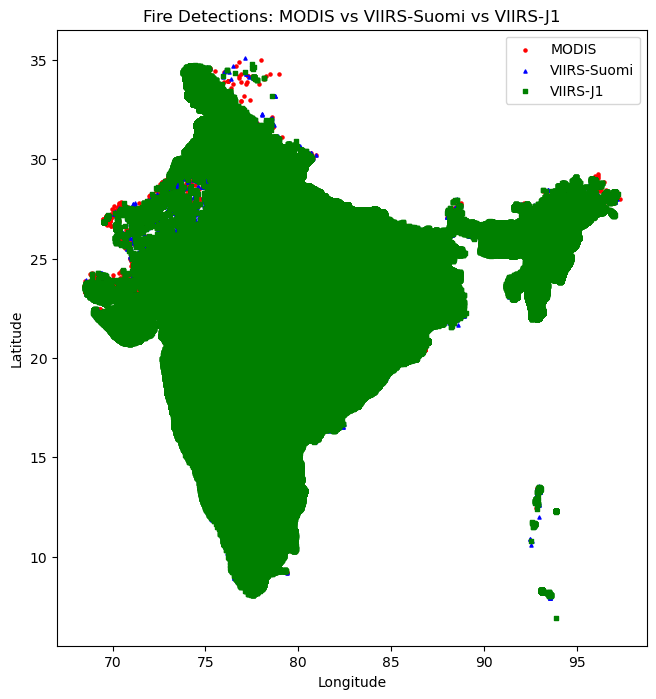

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Update these folder paths if needed
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    """Return the full path to the first .shp file in the folder."""
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    return None

def process_shapefile(shp_path, label="Dataset"):
    """Read a shapefile and print the first few rows."""
    if shp_path is None:
        print(f"No shapefile found for {label}.")
        return None
    print(f"\nProcessing {label} shapefile: {os.path.basename(shp_path)}")
    try:
        gdf = gpd.read_file(shp_path)
        print(gdf.head())
        return gdf
    except MemoryError:
        print("MemoryError: File too large to load in memory.")
    except Exception as e:
        print(f"Error reading {shp_path}: {e}")
    return None

# Get shapefile paths
modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

# Process and load GeoDataFrames
modis_gdf = process_shapefile(modis_shp, label="MODIS")
viirs_snp_gdf = process_shapefile(viirs_snp_shp, label="VIIRS-Suomi")
viirs_j1_gdf = process_shapefile(viirs_j1_shp, label="VIIRS-J1")

# Visualization if all datasets loaded
if all([modis_gdf is not None, viirs_snp_gdf is not None, viirs_j1_gdf is not None]):
    fig, ax = plt.subplots(figsize=(12, 8))
    modis_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='MODIS')
    viirs_snp_gdf.plot(ax=ax, marker='^', color='blue', markersize=5, label='VIIRS-Suomi')
    viirs_j1_gdf.plot(ax=ax, marker='s', color='green', markersize=5, label='VIIRS-J1')
    plt.legend()
    plt.title('Fire Detections: MODIS vs VIIRS-Suomi vs VIIRS-J1')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("One or more datasets could not be loaded. Visualization skipped.")



In [2]:
import os
print(os.getcwd())
print(os.listdir('.'))


C:\Users\arins
['-1.14-windows.xml', '.anaconda', '.android', '.arduinoIDE', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.cursor', '.docker', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lesshst', '.matplotlib', '.ms-ad', '.node_repl_history', '.vscode', '.vscode-cli', '220107016.ipynb', '220107016_Clean_D6.ipynb', '220107016_tut7.ipynb', 'agro', 'Amex Hack', 'anaconda', 'anaconda3', 'AppData', 'Application Data', 'backend', 'best_model.pth', 'C LANGUAGE', 'C++', 'CF', 'code prac', 'Cookies', 'Customer-Sales-Data-Analysis', 'data', 'Documents', 'Downloads', 'Favorites', 'feature_correlation_heatmap.png', 'feature_label_correlation.csv', 'feature_stack.tif', 'feature_stack_memmap.dat', 'feature_stack_memmap.npy', 'feature_statistics.csv', 'frontend-assignment', 'gcc', 'git_demo', 'homeprices.csv', 'ISRO_Data_processing-Copy1.ipynb', 'ISRO_Data_processing.ipynb', 'ISRO_EDA-Copy1.ipynb', 'ISRO_EDA.ipynb', 'ISRO_EDA_&_Data_Processing-Copy1.ip

In [3]:
# import os
# import geopandas as gpd
# from shapely.geometry import box
# import matplotlib.pyplot as plt

# # === UPDATE THESE PATHS TO WHERE YOUR DATA FOLDERS ACTUALLY ARE ===
# modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
# viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
# viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

# def get_shapefile_path(folder_path):
#     if not os.path.exists(folder_path):
#         print(f"Folder not found: {folder_path}")
#         return None
#     for file in os.listdir(folder_path):
#         if file.endswith('.shp'):
#             return os.path.join(folder_path, file)
#     print(f"No shapefile found in: {folder_path}")
#     return None

# # Load shapefiles
# modis_shp = get_shapefile_path(modis_folder)
# viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
# viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

# modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
# viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
# viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# # Define Uttarakhand bounding box
# uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

# def filter_by_bbox(gdf, bbox):
#     if gdf is None:
#         return None
#     return gdf[gdf.geometry.within(bbox)]

# # Filter for Uttarakhand region
# modis_uttarakhand = filter_by_bbox(modis_gdf, uttarakhand_bbox)
# viirs_snp_uttarakhand = filter_by_bbox(viirs_snp_gdf, uttarakhand_bbox)
# viirs_j1_uttarakhand = filter_by_bbox(viirs_j1_gdf, uttarakhand_bbox)

# # Print number of points in each filtered dataset
# print("MODIS Uttarakhand fire points:", len(modis_uttarakhand) if modis_uttarakhand is not None else 0)
# print("VIIRS-Suomi Uttarakhand fire points:", len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0)
# print("VIIRS-J1 Uttarakhand fire points:", len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0)

# # Plot filtered points
# if all([modis_uttarakhand is not None, viirs_snp_uttarakhand is not None, viirs_j1_uttarakhand is not None]):
#     fig, ax = plt.subplots(figsize=(10, 8))
#     modis_uttarakhand.plot(ax=ax, marker='o', color='red', markersize=5, label='MODIS')
#     viirs_snp_uttarakhand.plot(ax=ax, marker='^', color='blue', markersize=5, label='VIIRS-Suomi')
#     viirs_j1_uttarakhand.plot(ax=ax, marker='s', color='green', markersize=5, label='VIIRS-J1')
#     plt.legend()
#     plt.title('Fire Detections in Uttarakhand: MODIS vs VIIRS-Suomi vs VIIRS-J1')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.show()
# else:
#     print("One or more Uttarakhand datasets could not be loaded or filtered.")


In [4]:
# import os
# import geopandas as gpd
# from shapely.geometry import box
# import matplotlib.pyplot as plt

# # Correct folder paths
# modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
# viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
# viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

# def get_shapefile_path(folder_path):
#     for file in os.listdir(folder_path):
#         if file.endswith('.shp'):
#             return os.path.join(folder_path, file)
#     return None

# # Load shapefiles
# modis_shp = get_shapefile_path(modis_folder)
# viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
# viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

# modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
# viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
# viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# # Uttarakhand bounding box
# uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

# def filter_by_bbox(gdf, bbox):
#     if gdf is None:
#         return None
#     return gdf[gdf.geometry.within(bbox)]

# modis_uttarakhand = filter_by_bbox(modis_gdf, uttarakhand_bbox)
# viirs_snp_uttarakhand = filter_by_bbox(viirs_snp_gdf, uttarakhand_bbox)
# viirs_j1_uttarakhand = filter_by_bbox(viirs_j1_gdf, uttarakhand_bbox)

# # Plot separate figures for each dataset
# datasets = [
#     ("MODIS Fire Detections in Uttarakhand", modis_uttarakhand, 'o', 'red'),
#     ("VIIRS-Suomi Fire Detections in Uttarakhand", viirs_snp_uttarakhand, '^', 'blue'),
#     ("VIIRS-J1 Fire Detections in Uttarakhand", viirs_j1_uttarakhand, 's', 'green')
# ]

# for title, gdf, marker, color in datasets:
#     plt.figure(figsize=(8, 6))
#     if gdf is not None and not gdf.empty:
#         gdf.plot(marker=marker, color=color, markersize=5)
#         plt.title(title)
#         plt.xlabel('Longitude')
#         plt.ylabel('Latitude')
#     else:
#         plt.text(0.5, 0.5, f'No data for {title}', horizontalalignment='center', verticalalignment='center')
#     plt.show()

# # Print counts for reference
# print(f"MODIS fire points in Uttarakhand: {len(modis_uttarakhand) if modis_uttarakhand is not None else 0}")
# print(f"VIIRS-Suomi fire points in Uttarakhand: {len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0}")
# print(f"VIIRS-J1 fire points in Uttarakhand: {len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0}")


MODIS high confidence fire points in Uttarakhand: 24446
VIIRS-Suomi high confidence fire points in Uttarakhand: 182340
VIIRS-J1 high confidence fire points in Uttarakhand: 131430


<Figure size 800x600 with 0 Axes>

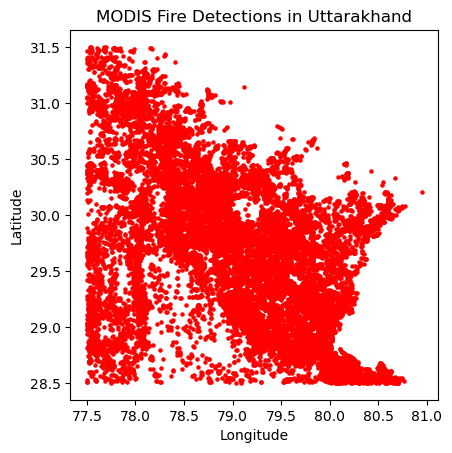

<Figure size 800x600 with 0 Axes>

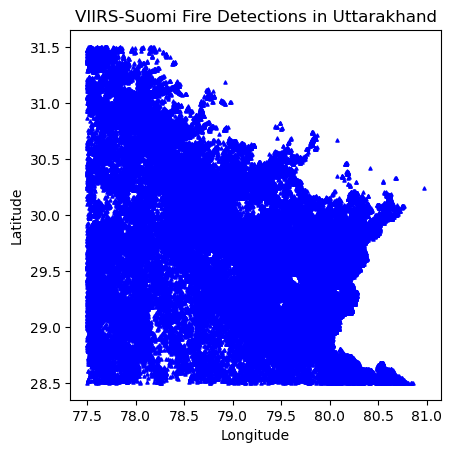

<Figure size 800x600 with 0 Axes>

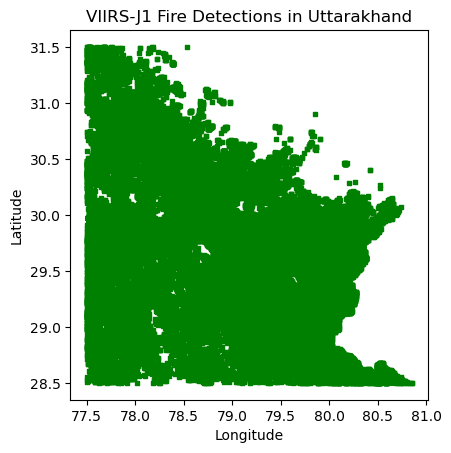

C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(
C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(
C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(


In [5]:
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Update these paths to where your data actually resides
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder does NOT exist: {folder_path}")
        return None
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    print(f"No .shp file found in: {folder_path}")
    return None

modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# Uttarakhand bounding box (approximate)
uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

def filter_by_bbox_and_confidence(gdf, bbox, conf_col='confidence', conf_thresh=75):
    if gdf is None:
        return None
    filtered = gdf[gdf.geometry.within(bbox)]
    if conf_col in filtered.columns:
        filtered = filtered[filtered[conf_col] >= conf_thresh]
    return filtered

modis_uttarakhand = filter_by_bbox_and_confidence(modis_gdf, uttarakhand_bbox)
viirs_snp_uttarakhand = filter_by_bbox_and_confidence(viirs_snp_gdf, uttarakhand_bbox)
viirs_j1_uttarakhand = filter_by_bbox_and_confidence(viirs_j1_gdf, uttarakhand_bbox)

# Print counts for reference
print(f"MODIS high confidence fire points in Uttarakhand: {len(modis_uttarakhand) if modis_uttarakhand is not None else 0}")
print(f"VIIRS-Suomi high confidence fire points in Uttarakhand: {len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0}")
print(f"VIIRS-J1 high confidence fire points in Uttarakhand: {len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0}")

# Plot separate figures for each dataset
datasets = [
    ("MODIS Fire Detections in Uttarakhand", modis_uttarakhand, 'o', 'red'),
    ("VIIRS-Suomi Fire Detections in Uttarakhand", viirs_snp_uttarakhand, '^', 'blue'),
    ("VIIRS-J1 Fire Detections in Uttarakhand", viirs_j1_uttarakhand, 's', 'green')
]

for title, gdf, marker, color in datasets:
    plt.figure(figsize=(8, 6))
    if gdf is not None and not gdf.empty:
        gdf.plot(marker=marker, color=color, markersize=5)
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
    else:
        plt.text(0.5, 0.5, f'No data for {title}', horizontalalignment='center', verticalalignment='center')
    plt.show()

# Optionally, save filtered points for rasterization or further ML processing
output_dir = r"C:\Users\arins\Downloads\uttarakhand_fire_points"
os.makedirs(output_dir, exist_ok=True)
if modis_uttarakhand is not None:
    modis_uttarakhand.to_file(os.path.join(output_dir, "modis_uttarakhand_highconf.shp"))
if viirs_snp_uttarakhand is not None:
    viirs_snp_uttarakhand.to_file(os.path.join(output_dir, "viirs_snp_uttarakhand_highconf.shp"))
if viirs_j1_uttarakhand is not None:
    viirs_j1_uttarakhand.to_file(os.path.join(output_dir, "viirs_j1_uttarakhand_highconf.shp"))


In [6]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [7]:
import geopandas as gpd
import numpy as np
from rasterio.transform import from_origin
from rasterio.features import rasterize
import rasterio

# Define Uttarakhand bounding box and raster parameters
minx, miny, maxx, maxy = 77.5, 28.5, 81.0, 31.5
pixel_size = 30  # meters

# Approximate meters per degree (at Uttarakhand latitude)
meters_per_deg_x = 111320
meters_per_deg_y = 110540

width = int((maxx - minx) * meters_per_deg_x / pixel_size)
height = int((maxy - miny) * meters_per_deg_y / pixel_size)

# Define raster transform (top-left origin)
transform = from_origin(minx, maxy, pixel_size / meters_per_deg_x, pixel_size / meters_per_deg_y)

def rasterize_points(gdf, transform, width, height, out_path):
    if gdf is None or gdf.empty:
        print("No data to rasterize.")
        return
    shapes = ((geom, 1) for geom in gdf.geometry)
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    # Save raster to GeoTIFF
    with rasterio.open(
        out_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='uint8',
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(raster, 1)
    print(f"Raster saved to {out_path}. Fire pixels: {np.sum(raster)}")

# Example usage for each dataset (update gdf variables as needed)
rasterize_points(modis_uttarakhand, transform, width, height, r"modis_fire_uttarakhand_30m.tif")
rasterize_points(viirs_snp_uttarakhand, transform, width, height, r"viirs_snp_fire_uttarakhand_30m.tif")
rasterize_points(viirs_j1_uttarakhand, transform, width, height, r"viirs_j1_fire_uttarakhand_30m.tif")


Raster saved to modis_fire_uttarakhand_30m.tif. Fire pixels: 24436
Raster saved to viirs_snp_fire_uttarakhand_30m.tif. Fire pixels: 181786
Raster saved to viirs_j1_fire_uttarakhand_30m.tif. Fire pixels: 131143


In [8]:
import os

out_dir = 'data'
os.makedirs(out_dir, exist_ok=True)


In [9]:
rasterize_points(modis_uttarakhand, transform, width, height, os.path.join(out_dir, "modis_fire_uttarakhand_30m.tif"))
rasterize_points(viirs_snp_uttarakhand, transform, width, height, os.path.join(out_dir, "viirs_snp_fire_uttarakhand_30m.tif"))
rasterize_points(viirs_j1_uttarakhand, transform, width, height, os.path.join(out_dir, "viirs_j1_fire_uttarakhand_30m.tif"))


Raster saved to data\modis_fire_uttarakhand_30m.tif. Fire pixels: 24436
Raster saved to data\viirs_snp_fire_uttarakhand_30m.tif. Fire pixels: 181786
Raster saved to data\viirs_j1_fire_uttarakhand_30m.tif. Fire pixels: 131143


In [10]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_Uttarakhand_100m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [11]:
# import os
# import rasterio
# import matplotlib.pyplot as plt
# import numpy as np

# # Directory containing the raster files
# data_dir = 'data'

# # List all .tif files in the data directory (excluding subdirectories)
# raster_files = [f for f in os.listdir(data_dir) if f.endswith('.tif') and os.path.isfile(os.path.join(data_dir, f))]

# def plot_raster(file_path, title):
#     with rasterio.open(file_path) as src:
#         raster_data = src.read(1)
#         # Mask no data values for better visualization
#         if src.nodata is not None:
#             raster_data = np.where(raster_data == src.nodata, np.nan, raster_data)
#         plt.figure(figsize=(8, 6))
#         plt.imshow(raster_data, cmap='viridis')
#         plt.title(title)
#         plt.colorbar(label='Value')
#         plt.xlabel('Column #')
#         plt.ylabel('Row #')
#         plt.show()

# # Visualize each raster one by one
# for raster_file in raster_files:
#     file_path = os.path.join(data_dir, raster_file)
#     print(f"Visualizing: {raster_file}")
#     plot_raster(file_path, raster_file)


# Remove Redundant and Irrelevant Layers
Remove LULC_30m.tif: Since you have both LULC_30m.tif and LULC_MODIS_Uttarakhand_500m.tif, but only one is at 30m resolution (required by your PS), keep the higher-resolution, Uttarakhand-specific LULC. If LULC_30m.tif covers your region at 30m, keep it and remove the MODIS 500m file; otherwise, keep the most relevant one for your study area and resolution.

Remove Population_30m.tif and Population_Uttarakhand_100m.tif: These layers seem to be empty or uniform, and population is not a required feature per your PS.

In [12]:
import os

files_to_remove = [
     # or 'data/LULC_30m.tif' if you prefer the MODIS one
    'data/Population_30m.tif',
    'data/Population_Uttarakhand_100m.tif'
]

for f in files_to_remove:
    if os.path.exists(f):
        os.remove(f)
        print(f"Removed {f}")
    else:
        print(f"{f} not found or already removed.")


data/Population_30m.tif not found or already removed.
Removed data/Population_Uttarakhand_100m.tif


In [13]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


# Reproject and Align All Rasters
Why: All rasters must have the same CRS, extent, and pixel alignment for stacking and ML input.

How: Use your highest-quality DEM as the reference (e.g., Uttarakhand_Elevation_30m.tif). Reproject and resample all other rasters to match its CRS, bounds, and resolution.

In [14]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

data_dir = 'data'
feature_files = [
    'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'modis_fire_uttarakhand_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'VIIRS_Fire_Uttarakhand_30m.tif', 
    'viirs_j1_fire_uttarakhand_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]
target_files = [
    'viirs_snp_fire_uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'modis_fire_uttarakhand_30m.tif'
]
all_files = feature_files + target_files

# Reference raster
ref_path = os.path.join(data_dir, 'Uttarakhand_Elevation_30m.tif')
with rasterio.open(ref_path) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_shape = (ref.height, ref.width)

# Reproject and resample
reprojected_dir = os.path.join(data_dir, 'reprojected')
os.makedirs(reprojected_dir, exist_ok=True)
for fname in all_files:
    src_path = os.path.join(data_dir, fname)
    dst_path = os.path.join(reprojected_dir, fname)
    if not os.path.exists(src_path):
        print(f"Missing: {src_path}")
        continue
    with rasterio.open(src_path) as src:
        if src.crs != ref_crs or src.shape != ref_shape:
            print(f"Reprojecting/resampling {fname}")
            kwargs = src.meta.copy()
            kwargs.update({'crs': ref_crs, 'transform': ref_transform, 'width': ref_shape[1], 'height': ref_shape[0]})
            with rasterio.open(dst_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=ref_transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.nearest)
        else:
            # Copy as-is
            with rasterio.open(dst_path, 'w', **src.meta) as dst:
                dst.write(src.read())


Reprojecting/resampling Humidity_Uttarakhand_30m.tif
Reprojecting/resampling LULC_30m.tif
Reprojecting/resampling modis_fire_uttarakhand_30m.tif
Reprojecting/resampling MODIS_PFT_2023_Uttarakhand_30m.tif
Reprojecting/resampling NBR_Uttarakhand_30m.tif
Reprojecting/resampling NDVI_Uttarakhand_30m.tif
Reprojecting/resampling Rainfall_Uttarakhand_30m.tif
Reprojecting/resampling Temperature_Uttarakhand_30m.tif
Reprojecting/resampling VIIRS_Fire_Uttarakhand_30m.tif
Reprojecting/resampling viirs_j1_fire_uttarakhand_30m.tif
Reprojecting/resampling viirs_snp_fire_uttarakhand_30m.tif
Reprojecting/resampling WindSpeed_Uttarakhand_30m.tif
Reprojecting/resampling viirs_snp_fire_uttarakhand_30m.tif
Reprojecting/resampling viirs_j1_fire_uttarakhand_30m.tif
Reprojecting/resampling modis_fire_uttarakhand_30m.tif


# Normalize Continuous Features
Why: Neural networks and many ML models work best with normalized (0-1) or standardized features.

How: Min-max normalize continuous variables (elevation, slope, aspect, NDVI, NBR, temperature, rainfall, humidity, windspeed, etc.). Do not normalize categorical rasters (LULC, fire mask).

In [15]:
import numpy as np

continuous_features = [
   'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'modis_fire_uttarakhand_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'VIIRS_Fire_Uttarakhand_30m.tif', 
    'viirs_j1_fire_uttarakhand_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]
norm_arrays = {}
for f in continuous_features:
    path = os.path.join(reprojected_dir, f)
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        norm_arr = (arr - min_val) / (max_val - min_val) if max_val > min_val else arr
        norm_arrays[f] = norm_arr


LULC one-hot encoding

In [16]:
# import rasterio
# import numpy as np

# lulc_path = 'data/LULC_30m.tif'
# with rasterio.open(lulc_path) as src:
#     lulc = src.read(1)
#     classes = np.unique(lulc[~np.isnan(lulc)])  # Exclude nodata

# # One-hot encoding
# lulc_onehot = np.stack([(lulc == c).astype(np.uint8) for c in classes], axis=-1)
# print("LULC one-hot shape:", lulc_onehot.shape)  # (rows, cols, num_classes)


feature engineering on aspect

In [17]:
from PIL import Image

aspect_path = 'data/Uttarakhand_Aspect_30m.tif'

if os.path.exists(aspect_path):
    aspect_img = Image.open(aspect_path)
    aspect = np.array(aspect_img).astype(float)
    # Mask no data values (assuming 0 or 255 as nodata; adjust if your nodata is different)
    aspect[(aspect == 0) | (aspect == 255)] = np.nan
    # Convert degrees to radians
    aspect_rad = np.deg2rad(aspect)
    # Calculate sine and cosine
    aspect_sin = np.sin(aspect_rad)
    aspect_cos = np.cos(aspect_rad)
    print("aspect_sin shape:", aspect_sin.shape)
    print("aspect_cos shape:", aspect_cos.shape)
else:
    print('Aspect raster not found or loaded')


aspect_sin shape: (7454, 11133)
aspect_cos shape: (7454, 11133)


# PREPARING TARGET VARIABLE 
Creates a binary mask: 1 for fire, 0 for no fire.
Saves the result as a PNG (for visualization or ML input).

In [18]:
import numpy as np
from PIL import Image
import os

fire_raster_path = 'data/VIIRS_Fire_Uttarakhand_30m.tif'
output_path = 'data/fire_target_binary_uttarakhand_30m.png'

fire_mask = None

if os.path.exists(fire_raster_path):
    fire_img = Image.open(fire_raster_path)
    fire_data = np.array(fire_img).astype(float)
    # Treat 0 and 255 as nodata; adjust if your nodata is different
    fire_data[(fire_data == 0) | (fire_data == 255)] = np.nan
    fire_mask = np.where(np.isnan(fire_data), 0, 1).astype(np.uint8)
    fire_mask_img = Image.fromarray(fire_mask * 255)  # scale to 0-255 for saving
    fire_mask_img.save(output_path)
    print(f"Fire mask shape: {fire_mask.shape}")
    print(f"Number of fire pixels: {np.sum(fire_mask)}")
    print(f"Binary fire mask saved to: {output_path}")
else:
    print(f"Fire raster not found at {fire_raster_path}")


C:\Users\arins\anaconda\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (123370267 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fire mask shape: (9551, 12917)
Number of fire pixels: 5918583
Binary fire mask saved to: data/fire_target_binary_uttarakhand_30m.png


# FEATURE STACK CREATION

In [19]:
data_dir = '/absolute/path/to/your/data'  # Change this to your actual path

In [20]:
import os
print("Current working directory:", os.getcwd())
print("Files in data directory:", os.listdir('data') if os.path.exists('data') else "No data directory found")

Current working directory: C:\Users\arins
Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [21]:
pip install rasterio

In [22]:
# features = [
#     'Humidity_Uttarakhand_30m.tif',
#     'LULC_30m.tif',
#     'MODIS_PFT_2023_Uttarakhand_30m.tif',
#     'NBR_Uttarakhand_30m.tif',
#     'NDVI_Uttarakhand_30m.tif',
#     'Rainfall_Uttarakhand_30m.tif',
#     'Temperature_Uttarakhand_30m.tif',
#     'Uttarakhand_Slope_30m.tif',
#     'WindSpeed_Uttarakhand_30m.tif'
# ]


In [23]:
# import os
# import numpy as np
# import rasterio
# from rasterio.enums import Resampling
# from rasterio.windows import Window

# # Define your features
# features = [
#     'Humidity_Uttarakhand_30m.tif',
#     'LULC_30m.tif',
#     'MODIS_PFT_2023_Uttarakhand_30m.tif',
#     'NBR_Uttarakhand_30m.tif',
#     'NDVI_Uttarakhand_30m.tif',
#     'Rainfall_Uttarakhand_30m.tif',
#     'Temperature_Uttarakhand_30m.tif',
#     'Uttarakhand_Slope_30m.tif',
#     'WindSpeed_Uttarakhand_30m.tif'
# ]
# data_dir = 'data'
# TILE_SIZE = 2048
# X_OFF, Y_OFF = 0, 0  # top-left tile

# def stack_tile(file_list, data_dir, tile_size=2048, x_off=0, y_off=0):
#     arrays = []
#     ref_path = os.path.join(data_dir, file_list[0])
#     with rasterio.open(ref_path) as ref:
#         window = Window(x_off, y_off, tile_size, tile_size)
#         out_meta = ref.meta.copy()
#         out_meta.update({
#             'height': tile_size,
#             'width': tile_size,
#             'transform': rasterio.windows.transform(window, ref.transform)
#         })

#     for name in file_list:
#         path = os.path.join(data_dir, name)
#         with rasterio.open(path) as src:
#             arr = src.read(1, window=window).astype(np.float32)
#             if src.nodata is not None:
#                 arr[arr == src.nodata] = 0
#             arr = np.nan_to_num(arr, nan=0)
#             arrays.append(arr)

#     return np.stack(arrays, axis=-1), out_meta

# X_tile, tile_meta = stack_tile(features, data_dir, TILE_SIZE, X_OFF, Y_OFF)

In [24]:
# from PIL import Image

# def load_fire_mask_tile(mask_path, tile_size=2048, x_off=0, y_off=0):
#     full_mask = np.array(Image.open(mask_path)).astype(np.uint8)
#     return (full_mask[y_off:y_off+tile_size, x_off:x_off+tile_size] > 0).astype(np.uint8)

# y_tile = load_fire_mask_tile('data/fire_target_binary_uttarakhand_30m.png')

In [25]:
# stack = np.transpose(X_tile, (2, 0, 1))  # (C, H, W)


In [26]:
# PATCH_SIZE = 256
# STRIDE = 256

# def extract_patches(stack, mask, patch_size=256, stride=256):
#     C, H, W = stack.shape
#     X, y = [], []
#     for i in range(0, H - patch_size, stride):
#         for j in range(0, W - patch_size, stride):
#             x_patch = stack[:, i:i+patch_size, j:j+patch_size]
#             y_patch = mask[i:i+patch_size, j:j+patch_size]
#             if x_patch.shape[1:] == (patch_size, patch_size):
#                 X.append(x_patch)
#                 y.append(y_patch)
#     return np.array(X), np.expand_dims(np.array(y), axis=1)

# X, y = extract_patches(stack, y_tile)

In [27]:
# from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         return self.block(x)

# class UNet(nn.Module):
#     def __init__(self, in_ch, out_ch=1):
#         super().__init__()
#         self.enc1 = ConvBlock(in_ch, 64)
#         self.enc2 = ConvBlock(64, 128)
#         self.enc3 = ConvBlock(128, 256)
#         self.enc4 = ConvBlock(256, 512)
#         self.pool = nn.MaxPool2d(2)
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.dec3 = ConvBlock(512 + 256, 256)
#         self.dec2 = ConvBlock(256 + 128, 128)
#         self.dec1 = ConvBlock(128 + 64, 64)
#         self.final = nn.Conv2d(64, out_ch, kernel_size=1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         e3 = self.enc3(self.pool(e2))
#         e4 = self.enc4(self.pool(e3))
#         d3 = self.dec3(torch.cat([self.up(e4), e3], dim=1))
#         d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1))
#         d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
#         return torch.sigmoid(self.final(d1))

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE)
#         return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = UNet(in_ch=X.shape[1]).to(device)
# criterion = FocalLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
# val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
# train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
# val_dl = DataLoader(val_ds, batch_size=4)

# for epoch in range(1, 11):
#     model.train()
#     total_loss = 0
#     for xb, yb in train_dl:
#         xb, yb = xb.to(device), yb.to(device)
#         preds = model(xb)
#         loss = criterion(preds, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch}, Loss: {total_loss / len(train_dl):.4f}")

 Load and Normalize Features (Tile-based)

In [28]:
!pip install torch torchvision

In [29]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Convert to PyTorch format: (C, H, W)
# stack = np.transpose(feature_stack, (2, 0, 1))  # (C, H, W)
# mask = fire_mask.astype(np.uint8)  # (H, W)

# # Patchify
# PATCH_SIZE = 256
# STRIDE = 256

# def extract_patches(stack, mask, patch_size=256, stride=256):
#     C, H, W = stack.shape
#     patches_X = []
#     patches_y = []

#     for i in range(0, H - patch_size, stride):
#         for j in range(0, W - patch_size, stride):
#             x_patch = stack[:, i:i+patch_size, j:j+patch_size]
#             y_patch = mask[i:i+patch_size, j:j+patch_size]

#             if x_patch.shape[1:] == (patch_size, patch_size):
#                 patches_X.append(x_patch)
#                 patches_y.append(y_patch)

#     return np.array(patches_X), np.expand_dims(np.array(patches_y), axis=1)

# X, y = extract_patches(stack, mask)
# print("X shape:", X.shape)  # (N, C, 256, 256)
# print("y shape:", y.shape)  # (N, 1, 256, 256)

# # Split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# import torch
# import torch.nn as nn

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-BCE_loss)
#         loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
#         return loss.mean()


# re start

In [38]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import rasterio
from rasterio.windows import Window
from PIL import Image
import matplotlib.pyplot as plt

In [39]:
# Define your features
features = [
    'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]
data_dir = 'data'
TILE_SIZE = 2048
X_OFF, Y_OFF = 0, 0

def stack_tile(file_list, data_dir, tile_size=2048, x_off=0, y_off=0):
    arrays = []
    ref_path = os.path.join(data_dir, file_list[0])
    with rasterio.open(ref_path) as ref:
        window = Window(x_off, y_off, tile_size, tile_size)
        out_meta = ref.meta.copy()
        out_meta.update({
            'height': tile_size,
            'width': tile_size,
            'transform': rasterio.windows.transform(window, ref.transform)
        })

    for name in file_list:
        path = os.path.join(data_dir, name)
        with rasterio.open(path) as src:
            arr = src.read(1, window=window).astype(np.float32)
            if src.nodata is not None:
                arr[arr == src.nodata] = 0
            arr = np.nan_to_num(arr, nan=0)
            arr_min, arr_max = arr.min(), arr.max()
            if arr_max != arr_min:
                arr = (arr - arr_min) / (arr_max - arr_min)
            else:
                arr = np.zeros_like(arr)
            arrays.append(arr)

    return np.stack(arrays, axis=-1), out_meta

In [40]:
X_tile, tile_meta = stack_tile(features, data_dir, TILE_SIZE, X_OFF, Y_OFF)


In [41]:
### ✅ Stage 2: Prepare Binary Fire Label
from PIL import Image

def load_fire_mask_tile(mask_path, tile_size=2048, x_off=0, y_off=0):
    full_mask = np.array(Image.open(mask_path)).astype(np.uint8)
    return (full_mask[y_off:y_off+tile_size, x_off:x_off+tile_size] > 0).astype(np.uint8)

y_tile = load_fire_mask_tile('data/fire_target_binary_uttarakhand_30m.png')

C:\Users\arins\anaconda\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (123370267 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [42]:
## Stage 3: Convert to PyTorch Shape

stack = np.transpose(X_tile, (2, 0, 1))  # (C, H, W)

In [43]:
## Stage 4: Extract Patches (128x128)
PATCH_SIZE = 128
STRIDE = 128

def extract_patches(stack, mask, patch_size=128, stride=128):
    C, H, W = stack.shape
    X, y = [], []
    for i in range(0, H - patch_size, stride):
        for j in range(0, W - patch_size, stride):
            x_patch = stack[:, i:i+patch_size, j:j+patch_size]
            y_patch = mask[i:i+patch_size, j:j+patch_size]
            if x_patch.shape[1:] == (patch_size, patch_size):
                X.append(x_patch)
                y.append(y_patch)
    return np.array(X), np.expand_dims(np.array(y), axis=1)

X, y = extract_patches(stack, y_tile)

In [44]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [45]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         return self.block(x)

# class UNetShallow(nn.Module):
#     def __init__(self, in_ch, out_ch=1):
#         super().__init__()
#         self.enc1 = ConvBlock(in_ch, 32)
#         self.enc2 = ConvBlock(32, 64)
#         self.pool = nn.MaxPool2d(2)
#         self.bridge = ConvBlock(64, 128)

#         self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.dec1 = ConvBlock(64 + 128, 64)
#         self.dec2 = ConvBlock(64 + 32, 32)
#         self.final = nn.Conv2d(32, out_ch, kernel_size=1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         b = self.bridge(self.pool(e2))
#         d1 = self.dec1(torch.cat([self.up1(b), e2], dim=1))
#         d2 = self.dec2(torch.cat([self.up1(d1), e1], dim=1))
#         return torch.sigmoid(self.final(d2))

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1000, gamma=0):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE)
#         return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = UNetShallow(in_ch=X.shape[1]).to(device)
# criterion = FocalLoss(alpha=1000, gamma=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
# val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
# test_ds = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
# val_dl = DataLoader(val_ds, batch_size=32)
# test_dl = DataLoader(test_ds, batch_size=32)

# # Store metrics over time
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []
# train_precisions, val_precisions = [], []
# train_recalls, val_recalls = [], []

# for epoch in range(1, 11):
#     model.train()
#     total_loss = 0
#     y_true_train, y_pred_train = [], []

#     for xb, yb in train_dl:
#         xb, yb = xb.to(device), yb.to(device)
#         preds = model(xb)
#         loss = criterion(preds, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         preds_binary = (preds > 0.5).float()
#         y_true_train.append(yb.cpu().numpy().flatten())
#         y_pred_train.append(preds_binary.cpu().numpy().flatten())

#     y_true_train = np.concatenate(y_true_train)
#     y_pred_train = np.concatenate(y_pred_train)
#     tn, fp, fn, tp = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1]).ravel()
#     precision = precision_score(y_true_train, y_pred_train, zero_division=0)
#     recall = recall_score(y_true_train, y_pred_train, zero_division=0)
#     specificity = tn / (tn + fp) if (tn + fp) else 0
#     iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0
#     accuracy = (tp + tn) / (tp + tn + fp + fn)

#     print(f"Epoch {epoch}")
#     print(f"Train Loss: {total_loss / len(train_dl):.4f}")
#     print(f"Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, IoU: {iou:.4f}")
#     print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
#     train_losses.append(total_loss / len(train_dl))
#     train_accuracies.append(accuracy)
#     train_precisions.append(precision)
#     train_recalls.append(recall)


#     # Validation
#     model.eval()
#     val_loss = 0
#     y_true_val, y_pred_val = [], []
    
#     with torch.no_grad():
#         for xb, yb in val_dl:
#             xb, yb = xb.to(device), yb.to(device)
#             preds = model(xb)
#             loss = criterion(preds, yb)
#             val_loss += loss.item()
#             preds_binary = (preds > 0.5).float()
#             y_true_val.append(yb.cpu().numpy().flatten())
#             y_pred_val.append(preds_binary.cpu().numpy().flatten())

#     y_true_val = np.concatenate(y_true_val)
#     y_pred_val = np.concatenate(y_pred_val)
#     tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1]).ravel()
#     precision = precision_score(y_true_val, y_pred_val, zero_division=0)
#     recall = recall_score(y_true_val, y_pred_val, zero_division=0)
#     specificity = tn / (tn + fp) if (tn + fp) else 0
#     iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0
#     accuracy = (tp + tn) / (tp + tn + fp + fn)

#     print(f"Val Loss: {val_loss / len(val_dl):.4f}")
#     print(f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, IoU: {iou:.4f}")
#     print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")
#     val_losses.append(val_loss / len(val_dl))
#     val_accuracies.append(accuracy)
#     val_precisions.append(precision)
#     val_recalls.append(recall)


In [46]:
pip install torchsummary

In [47]:
# from torchsummary import summary

# # Input shape: (channels, height, width)
# # Replace 128 with your patch size, and X.shape[1] with number of input channels

# input_channels = X.shape[1]  # C from (C, H, W)
# summary(model, input_size=(input_channels, 128, 128))

In [48]:
# import matplotlib.pyplot as plt

# # Example metric lists (populate from training loop)
# epochs = list(range(1, len(train_losses) + 1))

# # Replace these with actual values from your loop
# # train_recalls = [...]
# # val_recalls = [...]
# # train_precisions = [...]
# # val_precisions = [...]
# # train_losses = [...]
# # val_losses = [...]
# # train_accuracies = [...]
# # val_accuracies = [...]

# train_error_rate = [1 - acc for acc in train_accuracies]
# val_error_rate = [1 - acc for acc in val_accuracies]

# plt.figure(figsize=(14, 10))

# # Recall
# plt.subplot(2, 2, 1)
# plt.plot(epochs, train_recalls, label='Train Recall', marker='o')
# plt.plot(epochs, val_recalls, label='Val Recall', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.title('Recall vs Epoch')
# plt.legend()
# plt.grid(True)

# # Precision
# plt.subplot(2, 2, 2)
# plt.plot(epochs, train_precisions, label='Train Precision', marker='o')
# plt.plot(epochs, val_precisions, label='Val Precision', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.title('Precision vs Epoch')
# plt.legend()
# plt.grid(True)

# # Loss
# plt.subplot(2, 2, 3)
# plt.plot(epochs, train_losses, label='Train Loss', marker='o')
# plt.plot(epochs, val_losses, label='Val Loss', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch')
# plt.legend()
# plt.grid(True)

# # Error Rate
# plt.subplot(2, 2, 4)
# plt.plot(epochs, train_error_rate, label='Train Error Rate', marker='o')
# plt.plot(epochs, val_error_rate, label='Val Error Rate', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Error Rate')
# plt.title('Error Rate vs Epoch')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


In [49]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [51]:
# from torchinfo import summary

# summary(model, input_size=(1, X.shape[1], 128, 128))  # (batch, channels, height, width)


In [52]:
# def visualize_feature_maps(model, input_tensor, layer_name="enc1"):
#     model.eval()
#     layer_output = None

#     def hook(module, input, output):
#         nonlocal layer_output
#         layer_output = output.detach().cpu()

#     handle = getattr(model, layer_name).register_forward_hook(hook)

#     with torch.no_grad():
#         _ = model(input_tensor.to(device))

#     handle.remove()

#     layer_output = layer_output.squeeze(0)  # remove batch dimension
#     num_filters = layer_output.shape[0]

#     plt.figure(figsize=(15, 15))
#     for i in range(min(num_filters, 16)):  # show first 16 filters
#         plt.subplot(4, 4, i+1)
#         plt.imshow(layer_output[i], cmap='gray')
#         plt.axis('off')
#         plt.title(f'{layer_name} - Filter {i}')
#     plt.tight_layout()
#     plt.show()

# # Call it like this
# input_tensor = torch.tensor(X[idx:idx+1]).float()
# visualize_feature_maps(model, input_tensor, layer_name='enc1')


In [53]:
pip install torchviz graphviz


Note: you may need to restart the kernel to use updated packages.


# UPDATED MODEL FOR BETTER GENERALIZATION

In [54]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)

class UNetShallow(nn.Module):
    def __init__(self, in_ch, out_ch=1):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.enc2 = ConvBlock(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.bridge = ConvBlock(64, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = ConvBlock(64 + 128, 64)
        self.dec2 = ConvBlock(64 + 32, 32)
        self.final = nn.Conv2d(32, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bridge(self.pool(e2))
        d1 = self.dec1(torch.cat([self.up1(b), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up1(d1), e1], dim=1))
        return torch.sigmoid(self.final(d2))

# ✅ ComboLoss: BCE + Soft IoU
class SoftIoULoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):
        eps = 1e-6
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum() - intersection
        return 1 - (intersection + eps) / (union + eps)

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.iou = SoftIoULoss()
        self.alpha = alpha

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.iou(inputs, targets)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetShallow(in_ch=X.shape[1]).to(device)
criterion = ComboLoss(alpha=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
test_ds = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

# Store metrics over time
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

for epoch in range(1, 11):
    model.train()
    total_loss = 0
    y_true_train, y_pred_train = [], []

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds_binary = (preds > 0.5).float()
        y_true_train.append(yb.cpu().numpy().flatten())
        y_pred_train.append(preds_binary.cpu().numpy().flatten())


    model.eval()

    y_true_train = np.concatenate(y_true_train)
    y_pred_train = np.concatenate(y_pred_train)
    tn, fp, fn, tp = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1]).ravel()
    precision = precision_score(y_true_train, y_pred_train, zero_division=0)
    recall = recall_score(y_true_train, y_pred_train, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"Epoch {epoch}")
    print(f"Train Loss: {total_loss / len(train_dl):.4f}")
    print(f"Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, IoU: {iou:.4f}")
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    train_losses.append(total_loss / len(train_dl))
    train_accuracies.append(accuracy)
    train_precisions.append(precision)
    train_recalls.append(recall)


    # Validation
    model.eval()
    val_loss = 0
    y_true_val, y_pred_val = [], []
    
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            preds_binary = (preds > 0.5).float()
            y_true_val.append(yb.cpu().numpy().flatten())
            y_pred_val.append(preds_binary.cpu().numpy().flatten())

    y_true_val = np.concatenate(y_true_val)
    y_pred_val = np.concatenate(y_pred_val)
    tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1]).ravel()
    precision = precision_score(y_true_val, y_pred_val, zero_division=0)
    recall = recall_score(y_true_val, y_pred_val, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"Val Loss: {val_loss / len(val_dl):.4f}")
    print(f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, IoU: {iou:.4f}")
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")
    val_losses.append(val_loss / len(val_dl))
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)


Epoch 1
Train Loss: 0.9569
Train Accuracy: 0.4895, Precision: 0.0853, Recall: 0.8562, Specificity: 0.4682, IoU: 0.0841
TP: 123615, FP: 1325957, FN: 20753, TN: 1167499
Val Loss: 0.9726
Val Accuracy: 0.0500, Precision: 0.0500, Recall: 1.0000, Specificity: 0.0000, IoU: 0.0500
TP: 33611, FP: 638133, FN: 0, TN: 0

Epoch 2
Train Loss: 0.9487
Train Accuracy: 0.6080, Precision: 0.1216, Recall: 0.9906, Specificity: 0.5858, IoU: 0.1215
TP: 143013, FP: 1032803, FN: 1355, TN: 1460653
Val Loss: 0.9722
Val Accuracy: 0.0500, Precision: 0.0500, Recall: 1.0000, Specificity: 0.0000, IoU: 0.0500
TP: 33611, FP: 638133, FN: 0, TN: 0

Epoch 3
Train Loss: 0.9173
Train Accuracy: 0.6722, Precision: 0.1363, Recall: 0.9343, Specificity: 0.6571, IoU: 0.1350
TP: 134886, FP: 855090, FN: 9482, TN: 1638366
Val Loss: 0.9641
Val Accuracy: 0.2613, Precision: 0.0634, Recall: 1.0000, Specificity: 0.2224, IoU: 0.0634
TP: 33611, FP: 496195, FN: 0, TN: 141938

Epoch 4
Train Loss: 0.9385
Train Accuracy: 0.7126, Precision: 0.1

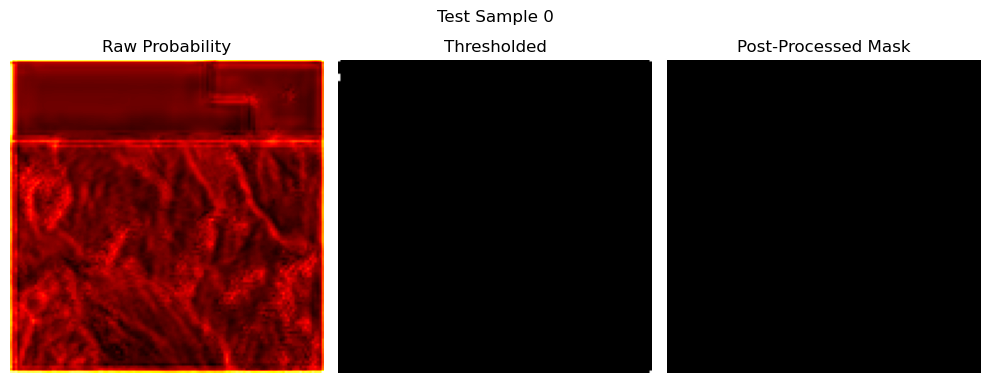

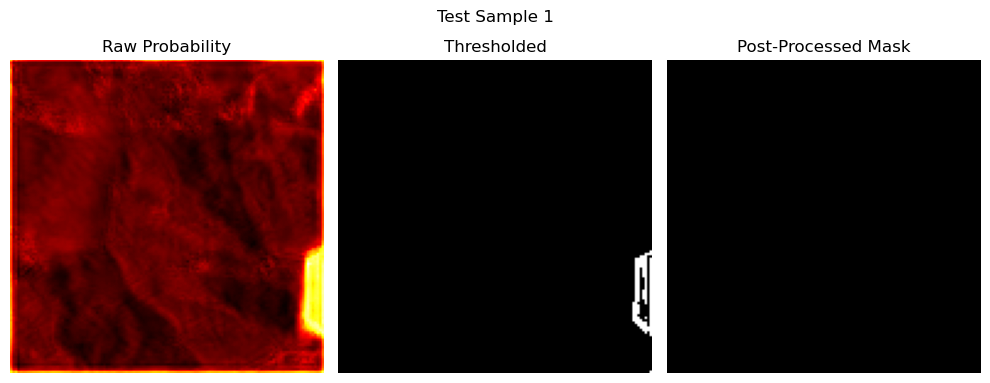

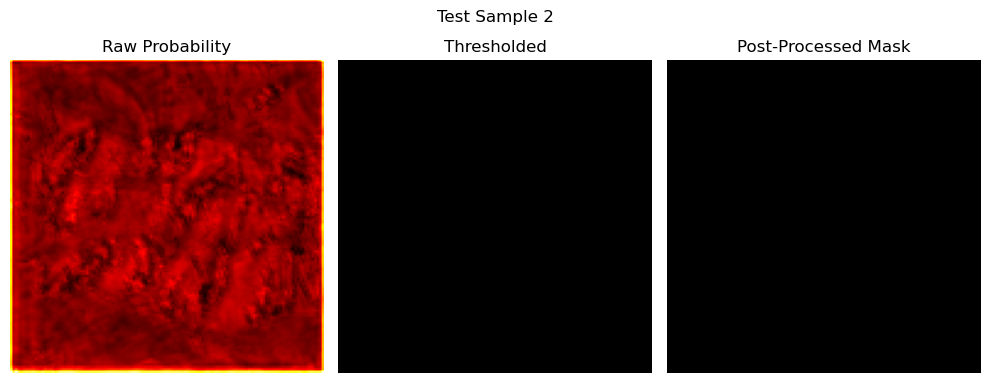

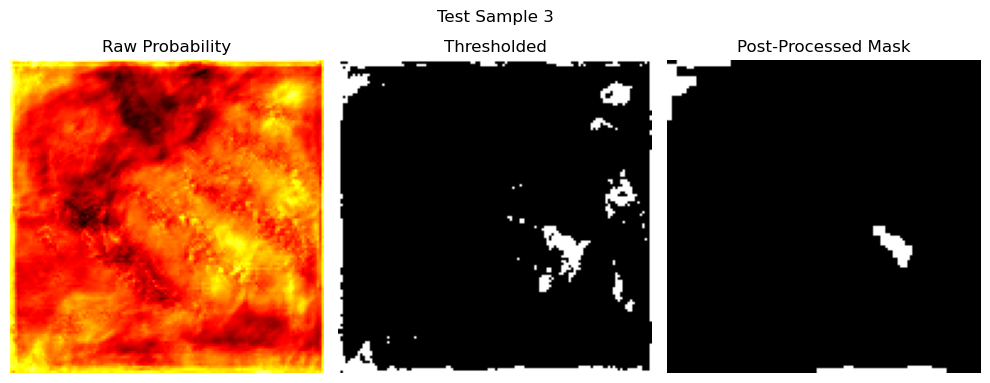

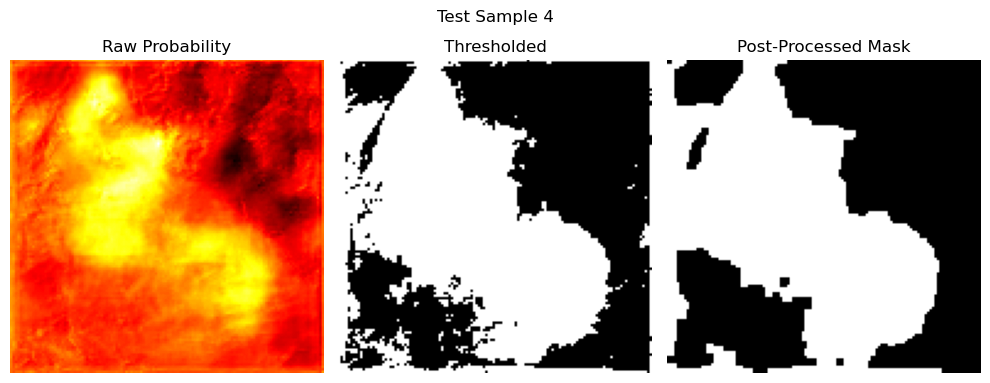

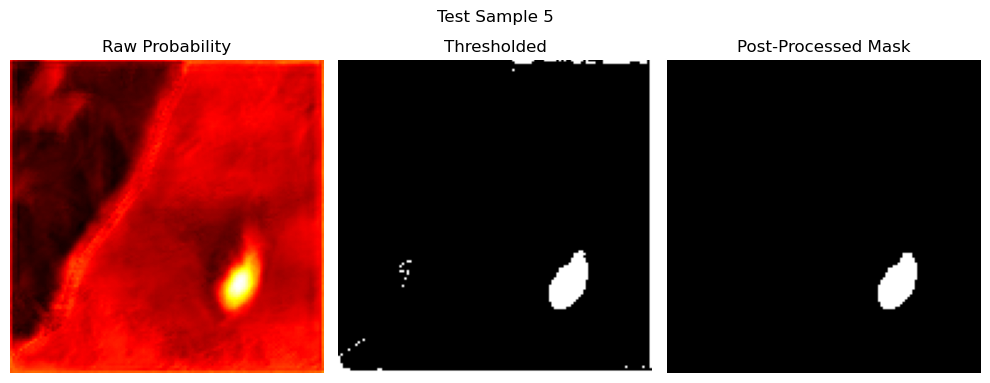

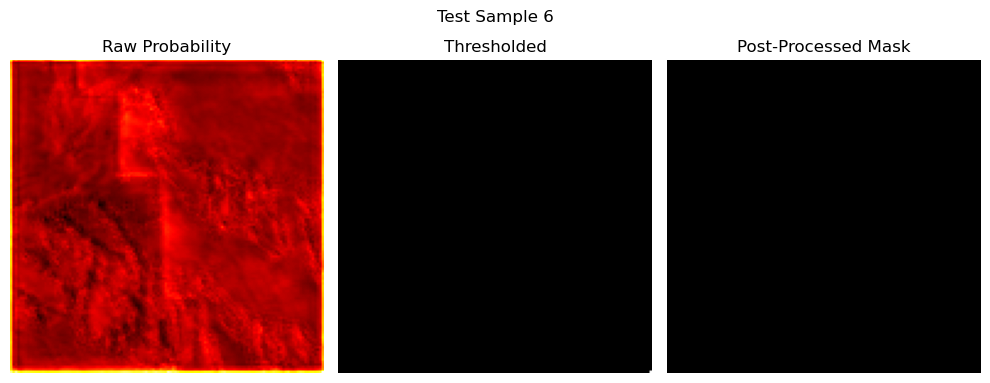

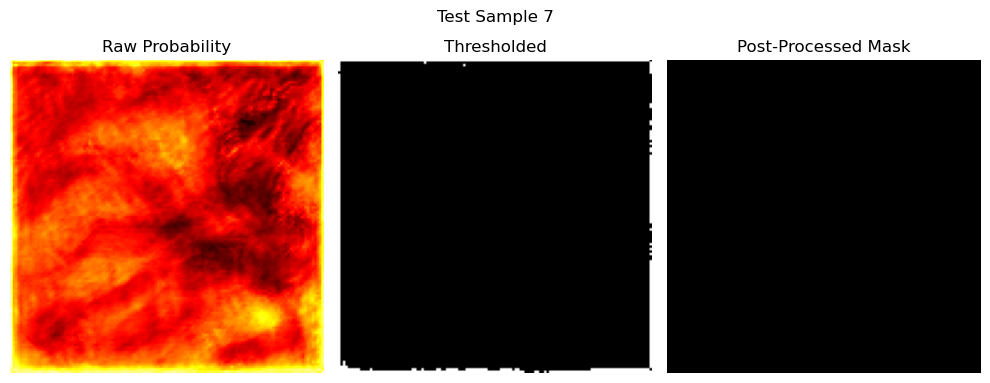

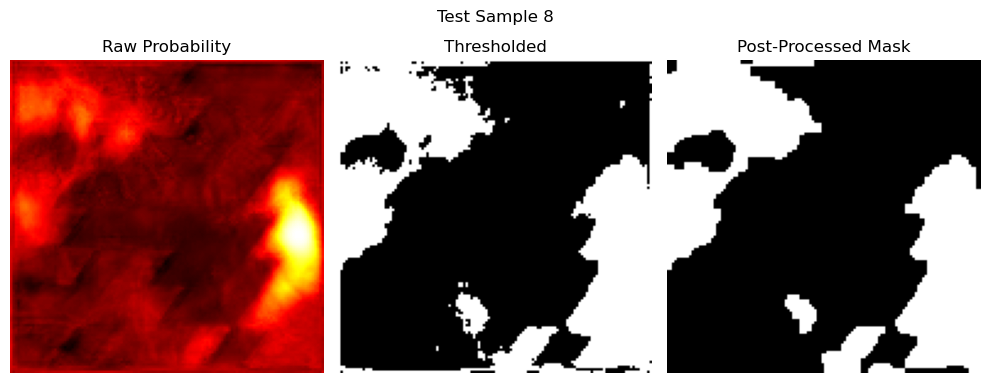

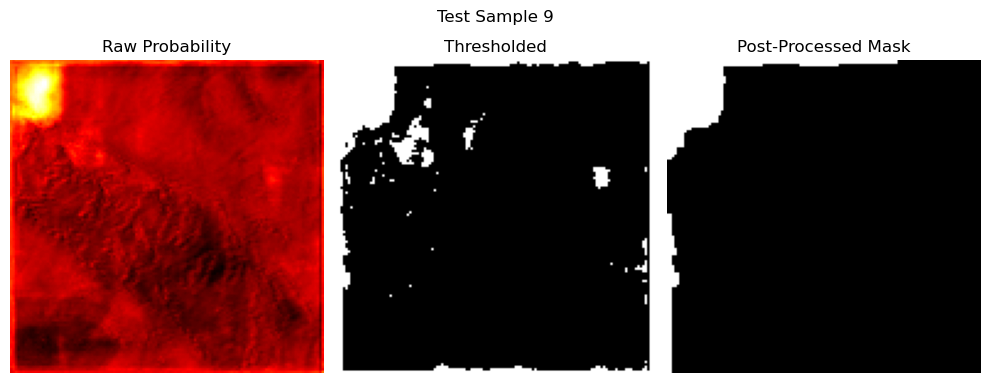

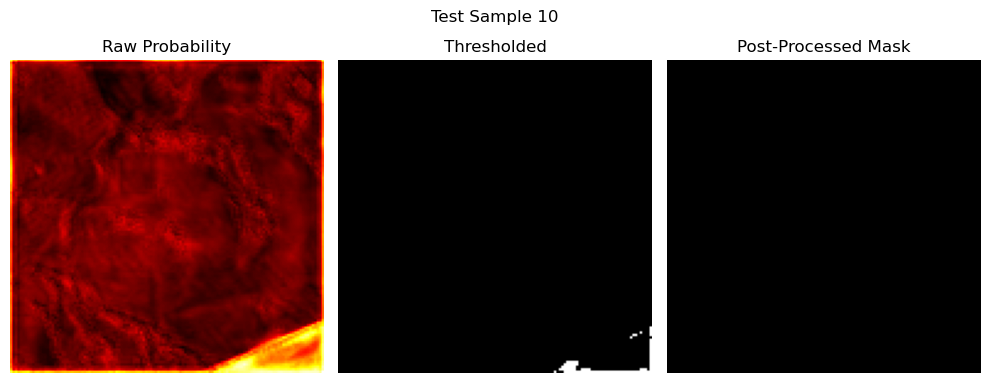

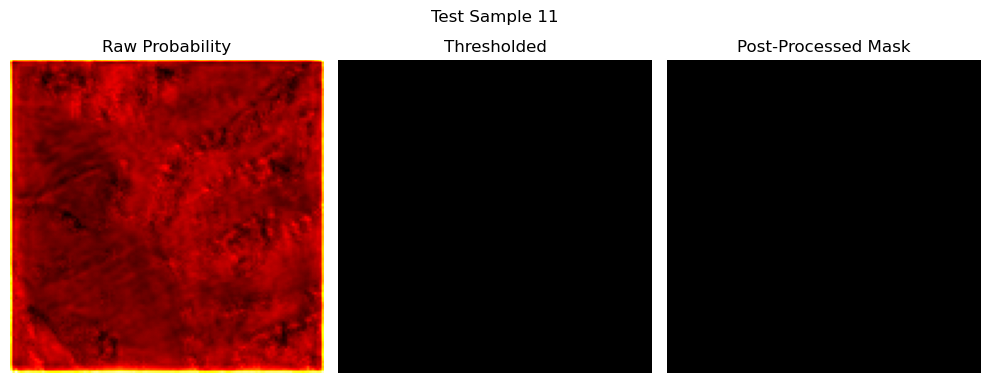

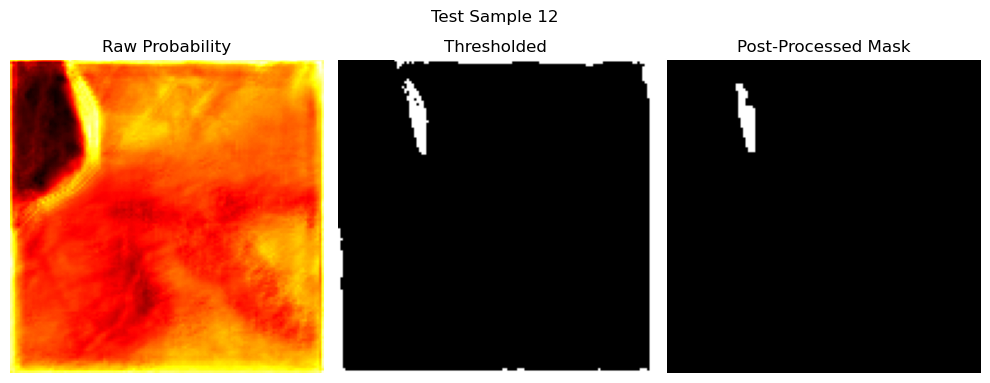

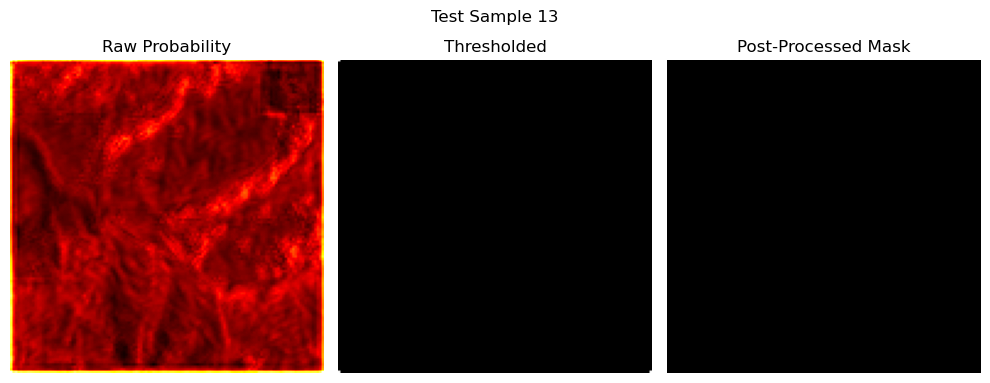

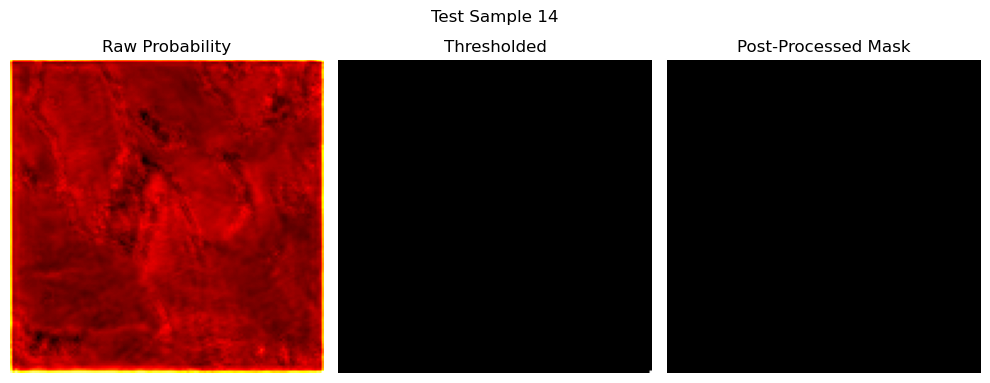

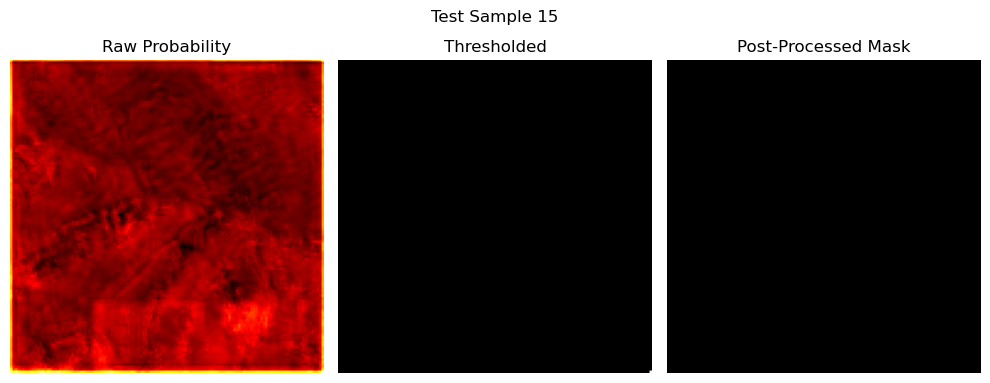

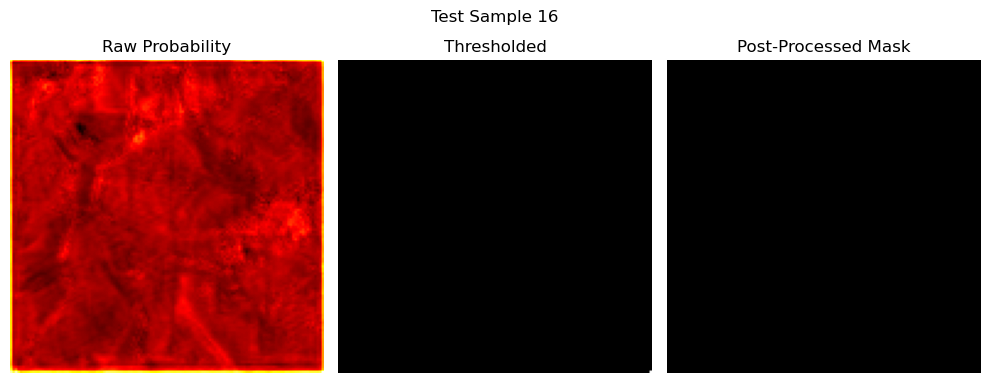

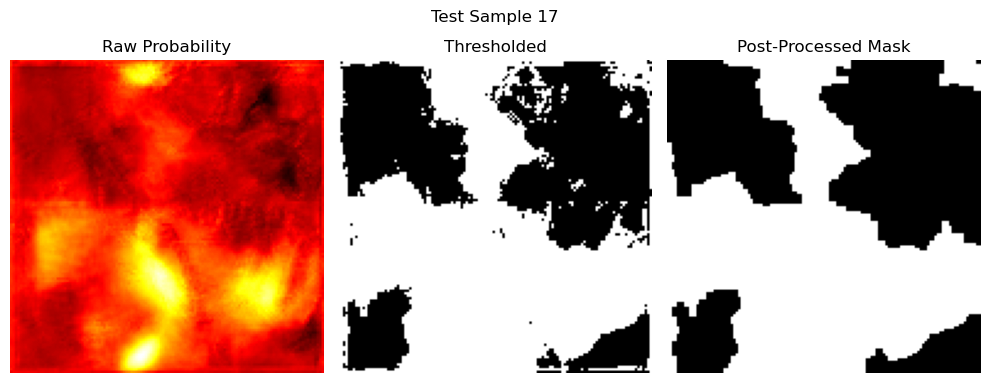

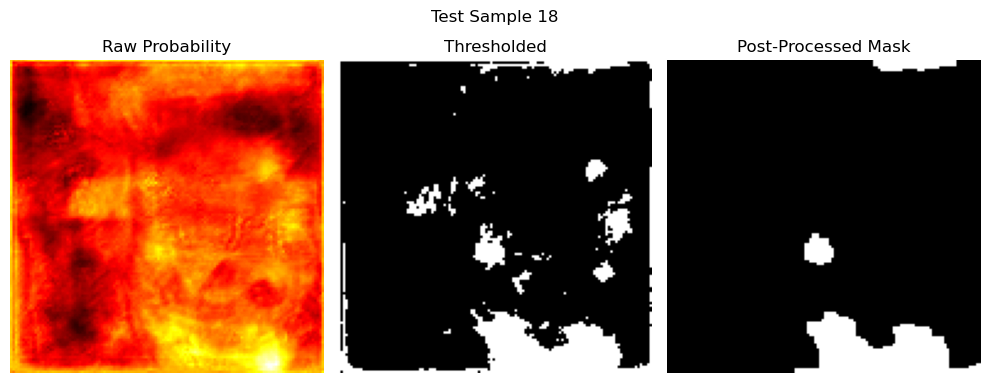

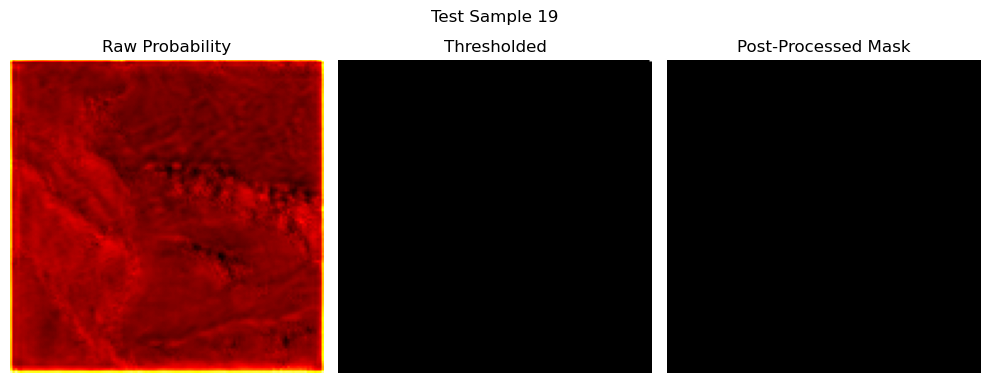

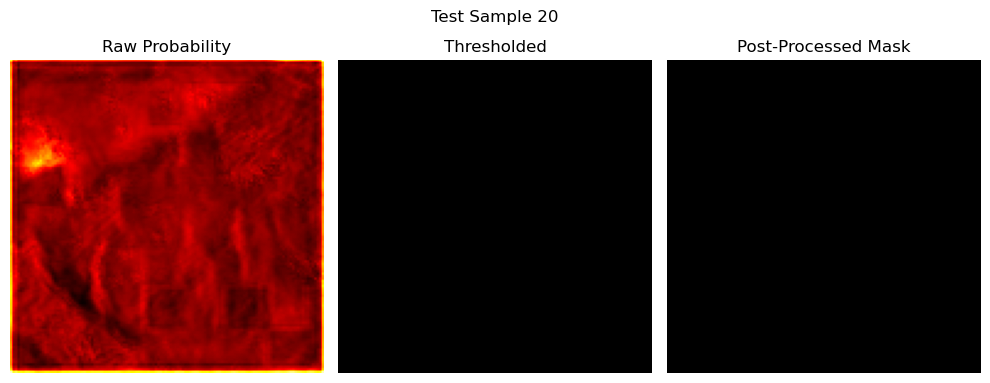

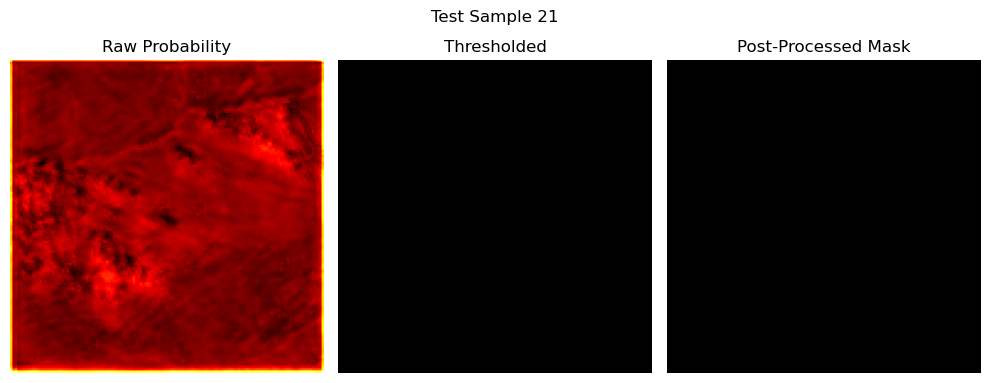

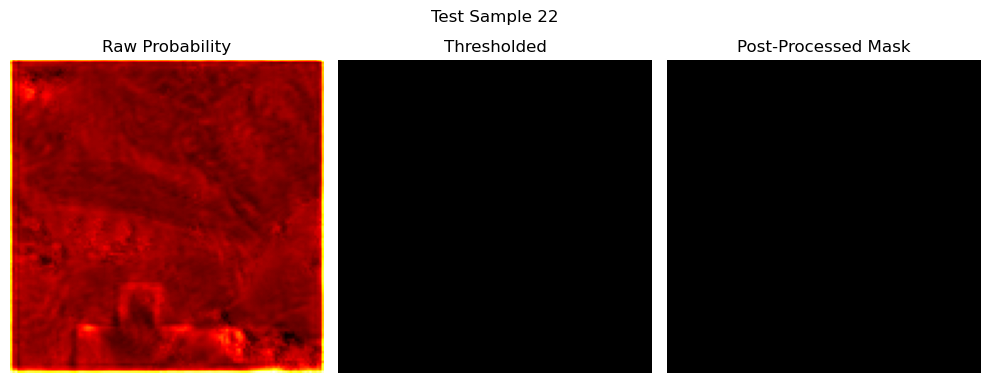

In [55]:
model.eval()

for batch_idx, (xb, yb) in enumerate(test_dl):
    xb = xb.to(device)
    with torch.no_grad():
        preds = model(xb)  # Output shape: (batch_size, 1, H, W)

    for i in range(preds.shape[0]):
        prob_map = preds[i, 0].cpu().numpy()  # (H, W)

        # Apply post-processing
        post_mask = post_process_mask(prob_map, threshold=0.5, min_area=100)

        # Visualization
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(prob_map, cmap='hot')
        plt.title('Raw Probability')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow((prob_map > 0.5).astype(np.uint8), cmap='gray')
        plt.title('Thresholded')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(post_mask, cmap='gray')
        plt.title('Post-Processed Mask')
        plt.axis('off')

        plt.suptitle(f"Test Sample {batch_idx * preds.shape[0] + i}")
        plt.tight_layout()
        plt.show()


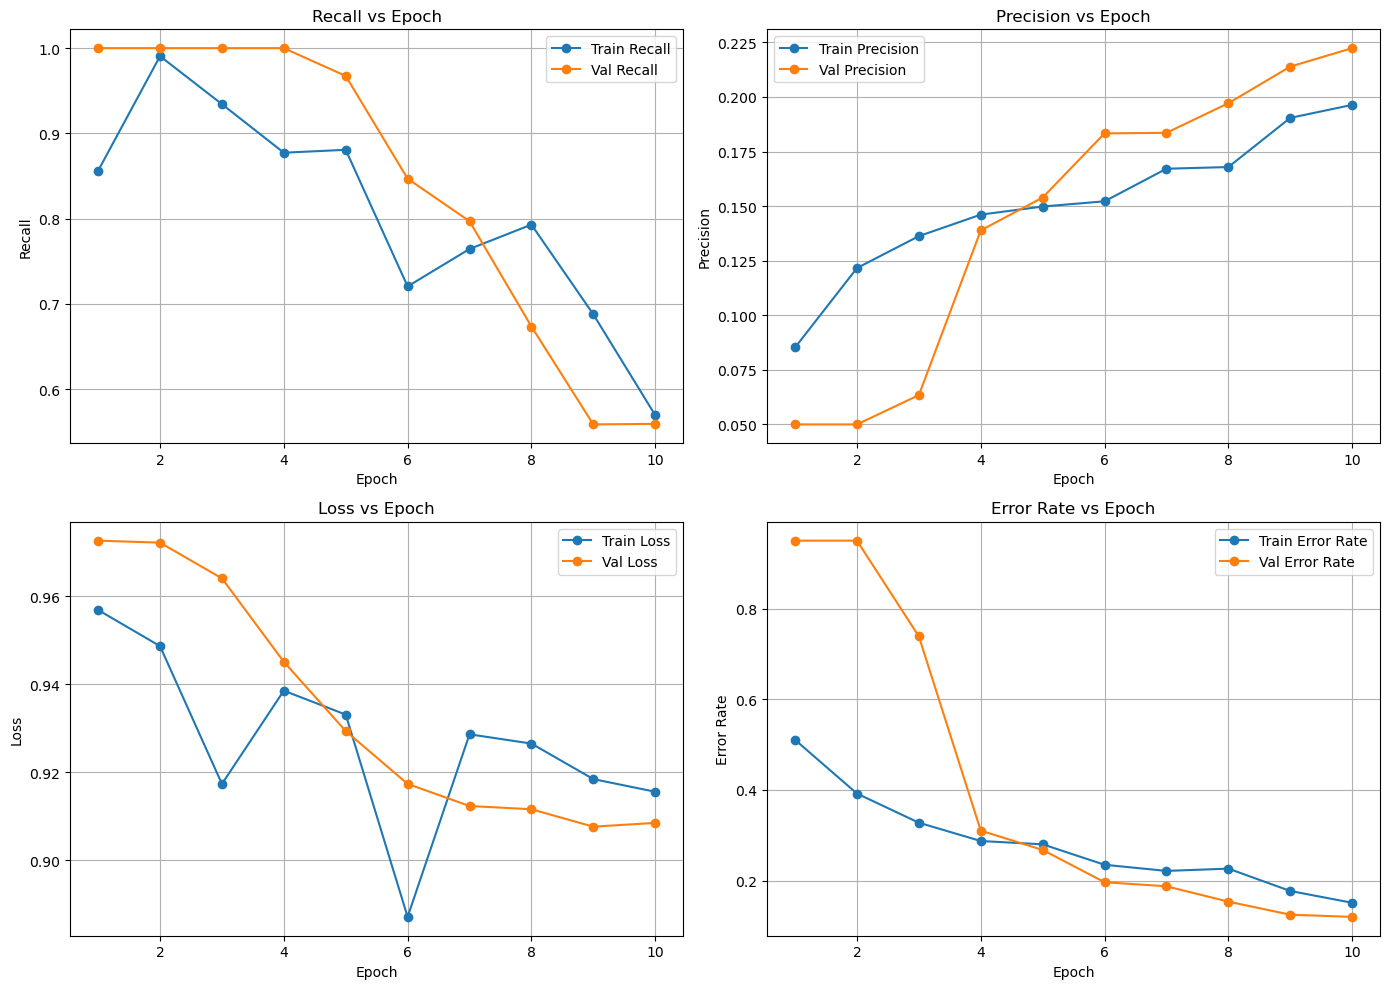

In [56]:
import matplotlib.pyplot as plt

# Example metric lists (populate from training loop)
epochs = list(range(1, len(train_losses) + 1))

# Replace these with actual values from your loop
# train_recalls = [...]
# val_recalls = [...]
# train_precisions = [...]
# val_precisions = [...]
# train_losses = [...]
# val_losses = [...]
# train_accuracies = [...]
# val_accuracies = [...]

train_error_rate = [1 - acc for acc in train_accuracies]
val_error_rate = [1 - acc for acc in val_accuracies]

plt.figure(figsize=(14, 10))

# Recall
plt.subplot(2, 2, 1)
plt.plot(epochs, train_recalls, label='Train Recall', marker='o')
plt.plot(epochs, val_recalls, label='Val Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precisions, label='Train Precision', marker='o')
plt.plot(epochs, val_precisions, label='Val Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

# Error Rate
plt.subplot(2, 2, 4)
plt.plot(epochs, train_error_rate, label='Train Error Rate', marker='o')
plt.plot(epochs, val_error_rate, label='Val Error Rate', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [57]:
# summary(model, input_size=(1, X.shape[1], 128, 128), col_names=["input_size", "output_size", "num_params"], depth=4)


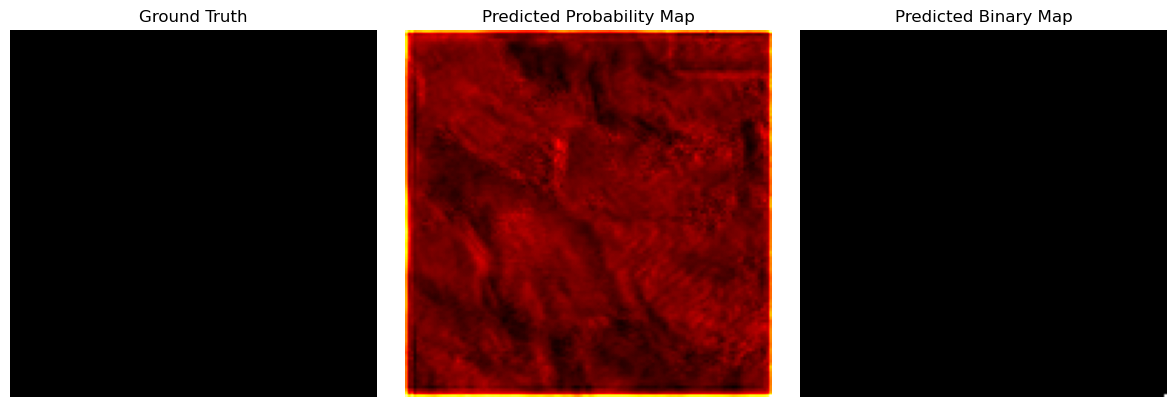

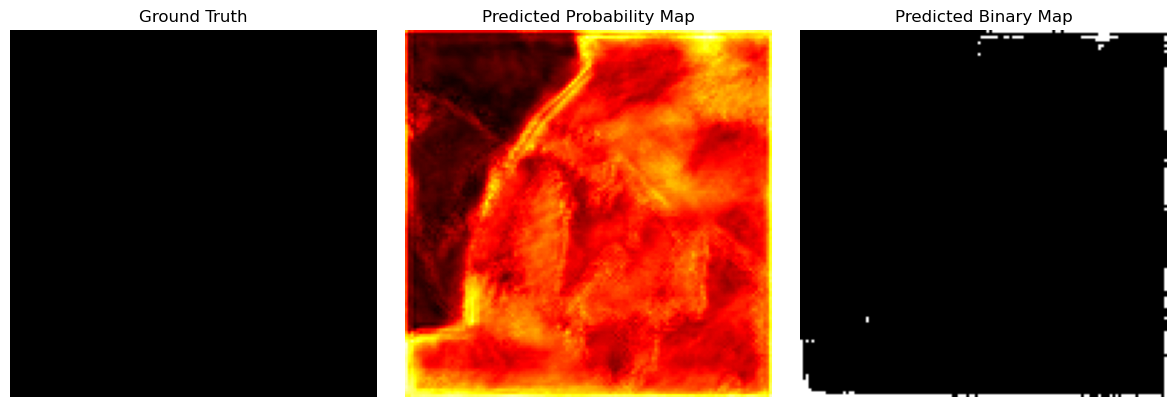

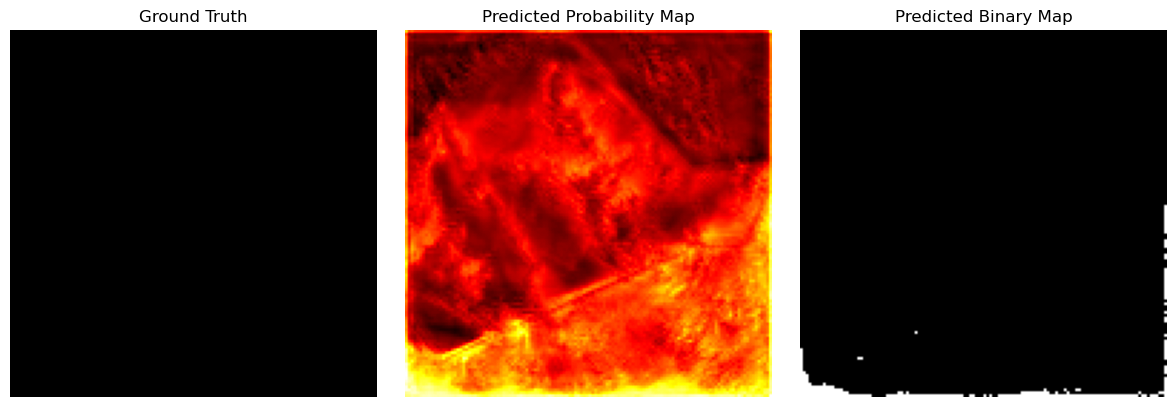

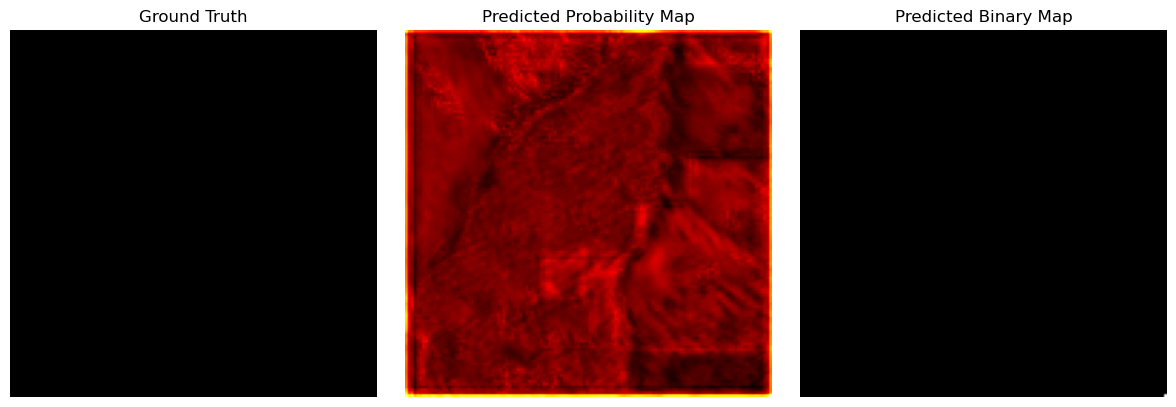

In [58]:
import matplotlib.pyplot as plt

# Load model in evaluation mode
model.eval()

# Predict on X_train
with torch.no_grad():
    X_tensor = torch.tensor(X_train).float().to(device)
    preds = model(X_tensor).cpu().numpy().squeeze()  # shape: (N, H, W)

# Ground truth from y_train
ground_truth = y_train.squeeze()  # shape: (N, H, W)

# Visualize 4 samples: original vs prediction
for i in range(4):
    prob_map = preds[i]
    pred_binary_map = (prob_map > 0.5).astype(np.uint8)
    original_map = ground_truth[i]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(original_map, cmap='gray')
    axs[0].set_title('Ground Truth')
    
    axs[1].imshow(prob_map, cmap='hot')
    axs[1].set_title('Predicted Probability Map')
    
    axs[2].imshow(pred_binary_map, cmap='gray')
    axs[2].set_title('Predicted Binary Map')

    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


In [59]:
# Check number of positive pixels in y_train
fire_counts = [np.sum(y) for y in y_train]
print("Number of fire-positive tiles:", sum(fc > 0 for fc in fire_counts))


Number of fire-positive tiles: 35


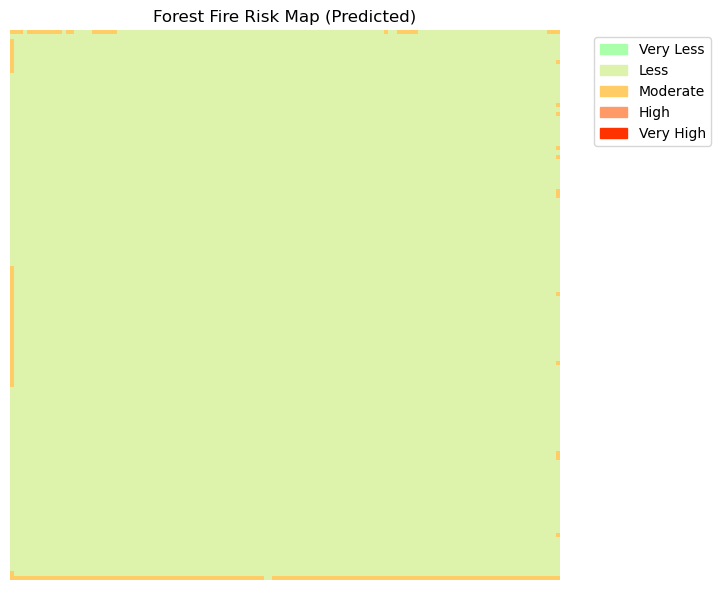

In [60]:
def classify_risk(prob_map):
    """
    Classify each pixel into 5 risk levels based on probability.
    """
    risk_map = np.zeros_like(prob_map, dtype=np.uint8)
    risk_map[(prob_map > 0.0)  & (prob_map <= 0.2)] = 1   # Very Less
    risk_map[(prob_map > 0.2)  & (prob_map <= 0.4)] = 2   # Less
    risk_map[(prob_map > 0.4)  & (prob_map <= 0.6)] = 3   # Moderate
    risk_map[(prob_map > 0.6)  & (prob_map <= 0.8)] = 4   # High
    risk_map[(prob_map > 0.8)] = 5                        # Very High
    return risk_map

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Assuming `preds` is already generated from model
# Combine all predictions into one map if using tiles (optional)

# For this example, we'll use one patch:
i = 0
prob_map = preds[i]  # shape: (H, W)
risk_map = classify_risk(prob_map)

# Define colormap and legend manually
colors = ['black', '#aaffaa', '#ddf2aa', '#ffcc66', '#ff9966', '#ff3300']
labels = ['Background', 'Very Less', 'Less', 'Moderate', 'High', 'Very High']
cmap = plt.matplotlib.colors.ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot map
plt.figure(figsize=(8, 6))
plt.imshow(risk_map, cmap=cmap, norm=norm)
plt.axis('off')

# Create legend
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(1, 6)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Forest Fire Risk Map (Predicted)")
plt.tight_layout()
plt.show()


Invalid switch - "".


# Applying dropout after both convolutional layers in each block 

In [62]:
# # ----------------------
# # Model Components
# # ----------------------
# import torch
# import torch.nn as nn

# class FocalTverskyLoss(nn.Module):
#     def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, eps=1e-7):
#         super().__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.gamma = gamma
#         self.eps = eps

#     def forward(self, preds, targets):
#         probs = torch.sigmoid(preds)
#         tp = (probs * targets).sum(dim=(1,2,3))
#         fp = ((1 - targets) * probs).sum(dim=(1,2,3))
#         fn = (targets * (1 - probs)).sum(dim=(1,2,3))
#         tversky = (tp + self.eps) / (tp + self.alpha * fp + self.beta * fn + self.eps)
#         loss = torch.pow((1 - tversky), self.gamma)
#         return loss.mean()


# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch, dropout):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout),
#         )

#     def forward(self, x):
#         return self.block(x)

# class UNetForecast(nn.Module):
#     def __init__(self, in_ch):
#         super().__init__()
#         self.enc1 = ConvBlock(in_ch, 32, dropout=0.05)
#         self.pool1 = nn.MaxPool2d(2)

#         self.enc2 = ConvBlock(32, 64, dropout=0.1)
#         self.pool2 = nn.MaxPool2d(2)

#         self.enc3 = ConvBlock(64, 128, dropout=0.15)

#         self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
#         self.dec2 = ConvBlock(128, 64, dropout=0.1)

#         self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
#         self.dec1 = ConvBlock(64, 32, dropout=0.05)

#         self.out = nn.Conv2d(32, 1, kernel_size=1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool1(e1))
#         e3 = self.enc3(self.pool2(e2))

#         d2 = self.dec2(torch.cat([self.up2(e3), e2], dim=1))
#         d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

#         return self.out(d1)

In [63]:
# # ----------------------
# # Data Split and Sampling
# # ----------------------
# # X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # # Create dataset
# # train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
# # val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())

# # Compute patch labels (1 if any fire pixel, else 0)
# patch_labels = (y_train.reshape(y_train.shape[0], -1).sum(axis=1) > 0).astype(int)
# class_sample_count = np.array([(patch_labels == 0).sum(), (patch_labels == 1).sum()])
# weights = 1. / class_sample_count
# sample_weights = torch.tensor([weights[t] for t in patch_labels], dtype=torch.float)


In [64]:
# # Weighted sampler
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
# train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler)
# val_dl = DataLoader(val_ds, batch_size=32)

In [65]:
# # ----------------------
# # Metric Computation
# # ----------------------
# def compute_metrics(preds, targets, threshold=0.5, forest_mask=None):
#     preds_bin = (torch.sigmoid(preds) > threshold).float()
#     targets_bin = (targets > 0.5).float()

#     if forest_mask is not None:
#         # forest_mask should be [B, 1, H, W] tensor on same device
#         preds_bin = preds_bin * forest_mask
#         targets_bin = targets_bin * forest_mask

#     tp = ((preds_bin == 1) & (targets_bin == 1)).sum().item()
#     tn = ((preds_bin == 0) & (targets_bin == 0)).sum().item()
#     fp = ((preds_bin == 1) & (targets_bin == 0)).sum().item()
#     fn = ((preds_bin == 0) & (targets_bin == 1)).sum().item()

#     accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
#     precision = tp / (tp + fp + 1e-8)
#     recall = tp / (tp + fn + 1e-8)
#     specificity = tn / (tn + fp + 1e-8)
#     iou = tp / (tp + fp + fn + 1e-8)

#     return {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'specificity': specificity,
#         'iou': iou,
#         'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
#     }



# # ----------------------
# # Training Loop
# # ----------------------
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = UNetForecast(in_ch=X.shape[1]).to(device)
# criterion = FocalTverskyLoss(alpha=0.3, beta=0.7, gamma=0.75)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# best_val_loss = float('inf')
# patience = 10
# trigger = 0

# metrics_history = {
#     'train_loss': [], 'val_loss': [],
#     'train_precision': [], 'val_precision': [],
#     'train_recall': [], 'val_recall': [],
#     'train_accuracy': [], 'val_accuracy': [],
#     'train_error': [], 'val_error': []
# }

# for epoch in range(1, 101):
#     model.train()
#     train_loss = 0
#     train_preds, train_targets = [], []
#     for xb, yb in train_dl:
#         xb, yb = xb.to(device), yb.to(device)
#         preds = model(xb)
#         loss = criterion(preds, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         train_preds.append(preds.detach().cpu())
#         train_targets.append(yb.detach().cpu())

#     model.eval()
#     val_loss = 0
#     val_preds, val_targets = [], []
#     with torch.no_grad():
#         for xb, yb in val_dl:
#             xb, yb = xb.to(device), yb.to(device)
#             preds = model(xb)
#             val_loss += criterion(preds, yb).item()
#             val_preds.append(preds.cpu())
#             val_targets.append(yb.cpu())

#     train_loss /= len(train_dl)
#     val_loss /= len(val_dl)

#     # Compute metrics
#     train_metrics = compute_metrics(torch.cat(train_preds), torch.cat(train_targets))
#     val_metrics = compute_metrics(torch.cat(val_preds), torch.cat(val_targets))

#     # Store for plotting
#     metrics_history['train_loss'].append(train_loss)
#     metrics_history['val_loss'].append(val_loss)
#     metrics_history['train_precision'].append(train_metrics['precision'])
#     metrics_history['val_precision'].append(val_metrics['precision'])
#     metrics_history['train_recall'].append(train_metrics['recall'])
#     metrics_history['val_recall'].append(val_metrics['recall'])
#     metrics_history['train_accuracy'].append(train_metrics['accuracy'])
#     metrics_history['val_accuracy'].append(val_metrics['accuracy'])
#     metrics_history['train_error'].append(1 - train_metrics['accuracy'])
#     metrics_history['val_error'].append(1 - val_metrics['accuracy'])

#     # Print metrics
#     print(f"\nEpoch {epoch}")
#     print(f"Train Loss: {train_loss:.4f}")
#     print(f"Train Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, Recall: {train_metrics['recall']:.4f}, Specificity: {train_metrics['specificity']:.4f}, IoU: {train_metrics['iou']:.4f}")
#     print(f"TP: {train_metrics['tp']}, FP: {train_metrics['fp']}, FN: {train_metrics['fn']}, TN: {train_metrics['tn']}")
#     print(f"Val Loss: {val_loss:.4f}")
#     print(f"Val Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, Specificity: {val_metrics['specificity']:.4f}, IoU: {val_metrics['iou']:.4f}")
#     print(f"TP: {val_metrics['tp']}, FP: {val_metrics['fp']}, FN: {val_metrics['fn']}, TN: {val_metrics['tn']}\n")

#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         trigger = 0
#         torch.save(model.state_dict(), "best_model.pth")
#     else:
#         trigger += 1
#         if trigger >= patience:
#             print(f"Early stopping at epoch {epoch}")
#             break


In [66]:
# epochs = list(range(1, len(metrics_history['train_loss']) + 1))

# # After model output and sigmoid
# preds_bin = (torch.sigmoid(preds) > threshold).float()

# # Apply forest mask here
# forest_mask = torch.tensor(forest_mask_array).unsqueeze(0).unsqueeze(0).float().to(preds.device)  # shape: [1, 1, H, W]
# preds_bin = preds_bin * forest_mask  # Only keep fire predictions over forest areas

# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.plot(epochs, metrics_history['train_loss'], label='Train')
# plt.plot(epochs, metrics_history['val_loss'], label='Val')
# plt.title("Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(epochs, metrics_history['train_precision'], label='Train')
# plt.plot(epochs, metrics_history['val_precision'], label='Val')
# plt.title("Precision")
# plt.xlabel("Epoch")
# plt.ylabel("Precision")
# plt.legend()

# plt.subplot(2, 2, 3)
# plt.plot(epochs, metrics_history['train_recall'], label='Train')
# plt.plot(epochs, metrics_history['val_recall'], label='Val')
# plt.title("Recall")
# plt.xlabel("Epoch")
# plt.ylabel("Recall")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.plot(epochs, metrics_history['train_error'], label='Train')
# plt.plot(epochs, metrics_history['val_error'], label='Val')
# plt.title("Error Rate")
# plt.xlabel("Epoch")
# plt.ylabel("Error Rate")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [67]:
# import matplotlib.pyplot as plt

# # Example metric lists (populate from training loop)
# epochs = list(range(1, len(train_losses) + 1))

# # Replace these with actual values from your loop
# # train_recalls = [...]
# # val_recalls = [...]
# # train_precisions = [...]
# # val_precisions = [...]
# # train_losses = [...]
# # val_losses = [...]
# # train_accuracies = [...]
# # val_accuracies = [...]

# train_error_rate = [1 - acc for acc in train_accuracies]
# val_error_rate = [1 - acc for acc in val_accuracies]

# plt.figure(figsize=(14, 10))

# # Recall
# plt.subplot(2, 2, 1)
# plt.plot(epochs, train_recalls, label='Train Recall', marker='o')
# plt.plot(epochs, val_recalls, label='Val Recall', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.title('Recall vs Epoch')
# plt.legend()
# plt.grid(True)

# # Precision
# plt.subplot(2, 2, 2)
# plt.plot(epochs, train_precisions, label='Train Precision', marker='o')
# plt.plot(epochs, val_precisions, label='Val Precision', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.title('Precision vs Epoch')
# plt.legend()
# plt.grid(True)

# # Loss
# plt.subplot(2, 2, 3)
# plt.plot(epochs, train_losses, label='Train Loss', marker='o')
# plt.plot(epochs, val_losses, label='Val Loss', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch')
# plt.legend()
# plt.grid(True)

# # Error Rate
# plt.subplot(2, 2, 4)
# plt.plot(epochs, train_error_rate, label='Train Error Rate', marker='o')
# plt.plot(epochs, val_error_rate, label='Val Error Rate', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Error Rate')
# plt.title('Error Rate vs Epoch')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


In [68]:
import gdown
# Dictionary of file IDs and output filenames
file_dict = {
    'Uttarakhand_Wind_Direction_30m.tif': '1KQA6NyTskOKjML3iqemLT3_59zWJYEAU',
}

# Make sure the 'data' directory exists
os.makedirs('data', exist_ok=True)

for filename, file_id in file_dict.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    out_path = os.path.join('data', filename)
    if not os.path.exists(out_path):
        print(f"Downloading {filename}...")
        gdown.download(url, out_path, quiet=False)
    else:
        print(f"{filename} already exists, skipping.")


Uttarakhand_Wind_Direction_30m.tif already exists, skipping.


In [69]:
import numpy as np
import cv2
from skimage import measure
from scipy import ndimage
import torch

def post_process_mask(prob_map, threshold=0.5, min_area=100, lulc_mask=None):
    """
    Applies post-processing steps to a probability or binary fire mask.
    
    Args:
        prob_map (np.array): Output from model (H, W), either probability or binary.
        threshold (float): Threshold to binarize probability map.
        min_area (int): Minimum area (in pixels) for a fire region to be retained.
        lulc_mask (np.array): Optional binary mask (H, W) to keep only burnable areas.
        
    Returns:
        np.array: Cleaned binary mask (H, W)
    """
    # Step 1: Thresholding
    binary_mask = (prob_map > threshold).astype(np.uint8)

    # Step 2: Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)  # remove small noise
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel) # fill holes

    # Step 3: Connected component filtering
    labeled_mask = measure.label(binary_mask, connectivity=2)
    cleaned_mask = np.zeros_like(binary_mask)
    for region in measure.regionprops(labeled_mask):
        if region.area >= min_area:
            cleaned_mask[labeled_mask == region.label] = 1

    # Step 4: Optional masking with LULC or PFT
    if lulc_mask is not None:
        cleaned_mask = np.logical_and(cleaned_mask, lulc_mask).astype(np.uint8)

    return cleaned_mask


In [70]:
def apply_watershed(binary_mask):
    """
    Separates closely located fire patches using watershed algorithm.
    """
    distance = ndimage.distance_transform_edt(binary_mask)
    local_maxi = cv2.dilate((distance > 1).astype(np.uint8), np.ones((3, 3)))
    markers = measure.label(local_maxi)
    labels = cv2.watershed(np.stack([binary_mask]*3, axis=-1).astype(np.uint8)*255, markers)
    separated = (labels > 1).astype(np.uint8)
    return separated


In [71]:
# Assuming `preds` is the output from the model (batch, 1, H, W)
for i in range(preds.shape[0]):
    prob_map = preds[i, 0].cpu().numpy()
    post_mask = post_process_mask(prob_map, threshold=0.5, min_area=100)
    
    # Optional: Apply watershed if needed
    # post_mask = apply_watershed(post_mask)

    plt.imshow(post_mask, cmap='hot')
    plt.title(f'Cleaned Fire Mask {i}')
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'